# 1、100跳的数
## 1.1 生成100跳时间误差数据

In [11]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算一百跳时间感知网络的时间误差
*  @FileName:   main_test_20250429.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Based on analysis of McCall et al. documents (2021-2022)

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import random
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 校正因子
    mean_link_delay_correction: float = 0.0  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.0  # NRR漂移校正有效性
    rr_drift_correction: float = 0.0  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops))  # 每次运行中每个跳的te
        }

        # 创建输出目录
        self.output_data_dir = 'output_data_test'
        self.output_image_dir = 'output_image_test'
        os.makedirs(self.output_data_dir, exist_ok=True)
        os.makedirs(self.output_image_dir, exist_ok=True)

    def generate_timestamp_error(self, is_tx: bool) -> float:
        """使用高斯分布而非均匀分布生成随机时间戳误差"""
        if is_tx:
            # 高斯分布，标准差为参数值的1/3
            # tsge = np.random.normal(0, self.params.tsge_tx/3)
            tsge = np.random.normal(0, self.params.tsge_tx)
            # dtse = np.random.normal(0, self.params.dtse_tx/3)
            dtse = np.random.normal(0, self.params.dtse_tx)
            # 限制极端值
            # tsge = np.clip(tsge, -self.params.tsge_tx, self.params.tsge_tx)
            # dtse = np.clip(dtse, -self.params.dtse_tx, self.params.dtse_tx)
        else:
            # 接收端同理
            tsge = np.random.normal(0, self.params.tsge_rx)
            # tsge = np.random.normal(0, self.params.tsge_rx/3)
            dtse = np.random.normal(0, self.params.dtse_rx)
            # dtse = np.random.normal(0, self.params.dtse_rx/3)
            # tsge = np.clip(tsge, -self.params.tsge_rx, self.params.tsge_rx)
            # dtse = np.clip(dtse, -self.params.dtse_rx, self.params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool) -> float:
        """根据参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= self.params.gm_clock_drift_fraction:
                return np.random.uniform(self.params.gm_clock_drift_min, self.params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= self.params.clock_drift_fraction:
                return np.random.uniform(self.params.clock_drift_min, self.params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self) -> float:
        """在规格范围内生成随机pDelay间隔"""
        return np.random.uniform(0.9 * self.params.pdelay_interval,
                                 1.3 * self.params.pdelay_interval)
    
    # 添加新的链路时延生成方法
    def generate_link_delay(self) -> float:
        """生成链路时延，包含基础时延和随机抖动"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = self.params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, self.params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 为所有节点生成时钟漂移
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True)  # GM
            for i in range(1, self.params.num_hops + 1):
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False)
                
                # 生成每个链路的传播时延
                nodes[i].link_delay = self.generate_link_delay()

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                # 生成时间戳误差
                nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False)

                # 为NRR计算生成先前的时间戳
                for n in range(1, self.params.mnrr_smoothing_n):
                    nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True))
                    nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False))

                # 计算NRR误差组件
                self.calculate_mnrr_errors(nodes, hop)

                # 计算RR误差
                if hop == 1:
                    nodes[hop].rr_error = nodes[hop].mnrr_error
                    nodes[hop].rr_error_sum = nodes[hop].rr_error
                else:
                    # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
                    pdelay_to_sync = np.random.uniform(0, self.params.pdelay_interval) * (
                                1.0 - self.params.pdelayresp_sync_correction)
                    rr_error_cd_nrr2sync = (pdelay_to_sync * (
                                nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                                       1.0 - self.params.nrr_drift_correction)

                    # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
                    rr_error_cd_rr2sync = (self.params.residence_time * (
                                nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                                      1.0 - self.params.rr_drift_correction)

                    # 累积RR误差
                    nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                        hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
                    nodes[hop].rr_error_sum = nodes[hop].rr_error

                # 真实的链路传播时延(ns)
                true_link_delay = nodes[hop].link_delay
                
                # pDelay报文实际传输时的延迟计算
                # t1→t2: 请求报文传输（受传播时延影响）
                # t3→t4: 响应报文传输（受传播时延影响）
                # t2→t3: 不计入链路延迟，为设备处理时间
                req_propagation = true_link_delay  # 请求报文的传播时延
                resp_propagation = true_link_delay  # 响应报文的传播时延
                
                # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
                # 理论上，完美测量应该得到：(t4-t1)-(t3-t2))/2 = 链路时延
                # 但测量会受时间戳误差影响
                timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
                measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
                
                # 链路延迟测量误差
                pdelay_error_ts = measured_link_delay - true_link_delay
                pdelay_error_ts *= (1.0 - self.params.mean_link_delay_correction)
                
                pdelay_error_nrr = -self.params.pdelay_turnaround * nodes[hop].mnrr_error / 2
                pdelay_error_nrr *= (1.0 - self.params.mean_link_delay_correction)
                
                nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

                # 修改: 对所有节点使用相同的误差计算方法（普通桥接设备方法）
                rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
                rt_error_rr = self.params.residence_time * nodes[hop].rr_error
                rt_error_cd_direct = (self.params.residence_time ** 2 * (
                            nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                                 1.0 - self.params.rr_drift_correction)

                nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct
                nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error

                # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳，则添加额外的时钟漂移误差
                if self.params.consider_next_sync and (
                        hop == self.params.num_hops or hop in self.params.end_station_hops):
                    # 计算到下一次同步到达之前积累的额外时钟漂移误差
                    additional_drift_error = (
                                self.params.time_to_next_sync * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                    nodes[hop].te += additional_drift_error

                # 更新下一跳的累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int):
        """计算给定跳的mNRR误差组件"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(self.params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval()

        # 计算由时间戳引起的mNRR误差
        if self.params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= self.params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - self.params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(self.output_data_dir, 'te_statistics.csv'), index=False)

    def plot_results(self):
        """绘制仿真结果并保存图像"""
        # 1. 绘制最终跳的te分布
        self.plot_final_hop_distribution()

        # 2. 绘制te随跳数的增长
        self.plot_te_growth()

        # 3. 绘制1-7跳的时间误差数据
        self.plot_first_seven_hops()

        # 4. 绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图
        self.plot_specific_hops_line_and_cdf()

    def plot_final_hop_distribution(self):
        """绘制最终跳的te分布"""
        plt.figure(figsize=(10, 6))
        final_hop_te = self.results['te_per_hop'][:, -1]
        plt.hist(final_hop_te, bins=50, alpha=0.7)
        # plt.axvline(x=self.results['te_7sigma'][-1], color='r', linestyle='--',
        #            label=f'7σ: {self.results["te_7sigma"][-1]:.1f} ns')
        # plt.axvline(x=-self.results['te_7sigma'][-1], color='r', linestyle='--')
        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Count')
        plt.title(f'te Distribution at Hop {self.params.num_hops}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'final_hop_te_distribution.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_te_growth(self):
        """绘制te随跳数的增长"""
        plt.figure(figsize=(10, 6))
        hops = np.arange(1, self.params.num_hops + 1)
        # plt.plot(hops, self.results['te_7sigma'], 'b-', label='7σ te')
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        # plt.title('te Growth Across Hops (7σ values)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_first_seven_hops(self):
        """绘制1-7跳的时间误差数据"""
        plt.figure(figsize=(12, 8))

        # 绘制箱形图
        first_seven_hops_data = [self.results['te_per_hop'][:, i] for i in range(7)]
        plt.boxplot(first_seven_hops_data, tick_labels=[f'Hop {i + 1}' for i in range(7)])
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # 绘制小提琴图
        plt.figure(figsize=(12, 8))
        first_seven_df = pd.DataFrame({f'Hop {i + 1}': self.results['te_per_hop'][:, i] for i in range(7)})
        sns.violinplot(data=first_seven_df)
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops (Violin Plot)')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te_violin.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_specific_hops_line_and_cdf(self):
        """绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图"""
        specific_hops = [10, 25, 50, 75, 100]
        specific_hops = [h for h in specific_hops if h <= self.params.num_hops]

        # 折线图 - 每次运行的te随时间的变化
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            # 选择100次运行进行可视化，否则图会太乱
            sample_runs = np.random.choice(self.params.num_runs, size=min(100, self.params.num_runs), replace=False)
            for run in sample_runs:
                if hop == specific_hops[0]:  # 只对第一个跳添加标签，避免重复
                    plt.plot(self.results['te_per_hop'][run, :hop], alpha=0.1, color=f'C{specific_hops.index(hop)}')

            # 绘制平均值线
            mean_values = np.mean(self.results['te_per_hop'][:, :hop], axis=0)
            plt.plot(mean_values, linewidth=2, label=f'Hop {hop} (avg)', color=f'C{specific_hops.index(hop)}')

        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Development for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_line.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # CDF图 - 最终te的累积分布
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            hop_data = self.results['te_per_hop'][:, hop - 1]
            sorted_data = np.sort(hop_data)
            # 计算每个值的CDF
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            plt.plot(sorted_data, cdf, label=f'Hop {hop}')

        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Cumulative Probability')
        plt.title('CDF of te for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_cdf.png'), dpi=300, bbox_inches='tight')
        plt.close()


# 使用推荐参数运行仿真
def main():
    # 使用推荐设置创建参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,  # 对应真实测试32跳数据

        # 时钟特性
        gm_clock_drift_max=1,
        gm_clock_drift_min=-1,
        gm_clock_drift_fraction=0.8,
        clock_drift_max=1,
        clock_drift_min=-1,
        clock_drift_fraction=0.8,

        # 时间戳误差
        tsge_tx=4.0,
        tsge_rx=4.0,
        dtse_tx=4.0,
        dtse_rx=4.0,

        # 消息间隔
        pdelay_interval=1000.0,
        sync_interval=125.0,
        pdelay_turnaround=0.5,
        residence_time=1,

        # 校正因子 - 推荐设置
        mean_link_delay_correction=0.9,
        nrr_drift_correction=0.9,
        rr_drift_correction=0.9,
        pdelayresp_sync_correction=0.9,
        mnrr_smoothing_n=3,
        mnrr_smoothing_m=1,

        # 终端站计算使用的特定跳
        end_station_hops=[10, 25, 50, 75, 100],

        # 下一次同步消息相关设置
        consider_next_sync=True,
        time_to_next_sync=125.0,  # 默认使用sync_interval
        
        # 链路时延参数
        link_delay_base=0.025,  # 25ns的基础链路时延
        link_delay_jitter=0.004,  # 1μs的链路时延抖动
        include_prop_delay=True,  # 启用传播时延仿真
    )

    # 创建并运行仿真
    sim = TimeSyncSimulation(params)
    print("Running simulation with recommended parameters...")
    sim.run_simulation()

    # 输出结果
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]

    print(f"Simulation complete!")
    print(f"Maximum te: {max_te:.1f} ns")
    print(f"7-sigma te at hop {params.num_hops}: {final_7sigma:.1f} ns")
    print(f"Target (<1000 ns): {'PASSED' if final_7sigma < 1000 else 'FAILED'}")

    # 绘制结果
    print("Generating plots...")
    sim.plot_results()
    print(f"Results saved to '{sim.output_data_dir}' and '{sim.output_image_dir}' directories.")


if __name__ == "__main__":
    main()

Running simulation with recommended parameters...
Simulation complete!
Maximum te: 294.3 ns
7-sigma te at hop 100: 564.6 ns
Target (<1000 ns): PASSED
Generating plots...
Results saved to 'output_data_test' and 'output_image_test' directories.


## 2.2 画一下箱线图看一下大概的数据趋势和量级

Loading data from D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\te_all_hops.csv...
Boxplot saved to output_image_test\te_boxplot_analysis.png


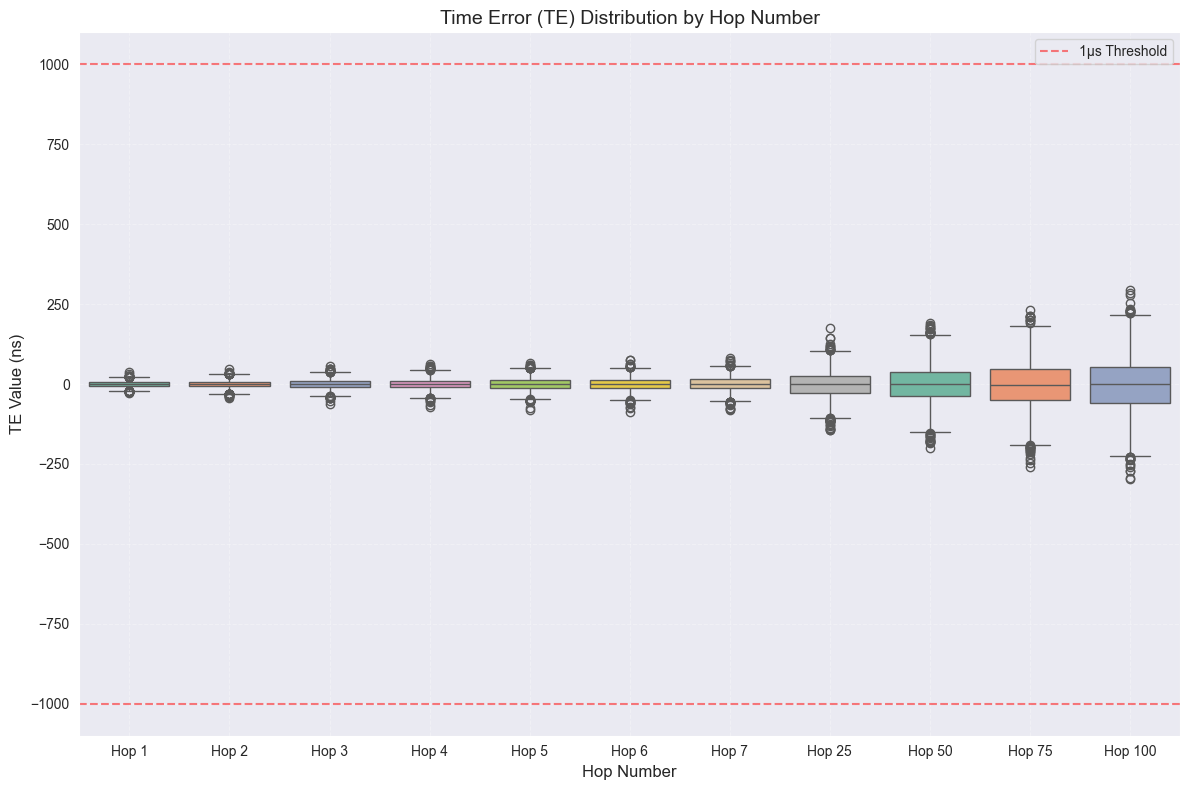

TE boxplot analysis completed successfully!


In [8]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   绘制TE箱线图分析
*  @FileName:   te_boxplot_analysis.py
**************************************
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List

class TEBoxplotAnalysis:
    """时间误差(TE)箱线图分析类"""
    
    def __init__(self, data_path: str):
        """
        初始化分析类
        
        参数:
            data_path (str): TE数据文件路径
        """
        self.data_path = data_path
        self.output_dir = 'output_image_test'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_data(self) -> pd.DataFrame:
        """加载TE数据"""
        print(f"Loading data from {self.data_path}...")
        return pd.read_csv(self.data_path)
    
    def preprocess_data(self, df: pd.DataFrame, target_hops: List[int]) -> pd.DataFrame:
        """
        预处理数据，筛选目标跳数
        
        参数:
            df (pd.DataFrame): 原始数据框
            target_hops (List[int]): 目标跳数列表
            
        返回:
            pd.DataFrame: 处理后的数据框
        """
        # 筛选目标列
        hop_columns = [f'Hop_{hop}' for hop in target_hops]
        
        # 检查列是否存在
        available_cols = [col for col in hop_columns if col in df.columns]
        if not available_cols:
            raise ValueError("None of the specified hop columns found in the data")
            
        return df[available_cols]
    
    def plot_te_boxplot(self, df: pd.DataFrame):
        """
        绘制TE箱线图
        
        参数:
            df (pd.DataFrame): 包含TE数据的数据框
        """
        plt.figure(figsize=(12, 8))
        
        # 使用seaborn绘制箱线图
        boxplot = sns.boxplot(data=df, palette="Set2")
        
        # 设置图形标题和标签
        plt.title('Time Error (TE) Distribution by Hop Number', fontsize=14)
        plt.xlabel('Hop Number', fontsize=12)
        plt.ylabel('TE Value (ns)', fontsize=12)
        
        # 添加参考线
        plt.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='1μs Threshold')
        plt.axhline(y=-1000, color='r', linestyle='--', alpha=0.5)
        
        # 添加网格线
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # 添加图例
        plt.legend()
        
        # 调整布局
        plt.tight_layout()
        
        # 保存图像
        output_path = os.path.join(self.output_dir, 'te_boxplot_analysis.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Boxplot saved to {output_path}")
        plt.show()
        plt.close()
    
    def run_analysis(self):
        """运行完整分析流程"""
        try:
            # 1. 加载数据
            te_data = self.load_data()
            
            # 2. 设置目标跳数
            target_hops = [1, 2, 3, 4, 5, 6, 7, 25, 50, 75, 100]
            
            # 3. 预处理数据
            processed_data = self.preprocess_data(te_data, target_hops)
            
            # 4. 重命名列名以便显示
            processed_data.columns = [f'Hop {col.split("_")[1]}' for col in processed_data.columns]
            
            # 5. 绘制箱线图
            self.plot_te_boxplot(processed_data)
            
            print("TE boxplot analysis completed successfully!")
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            raise

# 主函数
def main():
    # 设置数据文件路径
    data_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\te_all_hops.csv"
    
    # 创建分析实例并运行
    analyzer = TEBoxplotAnalysis(data_path)
    analyzer.run_analysis()

if __name__ == "__main__":
    main()


## 1.3 计算这些跳数的绝对值的最大值。

In [14]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算TE数据的绝对值最大值
*  @FileName:   te_max_calculator.py
**************************************
"""

import pandas as pd
import os
from typing import List, Dict

class TEMaxCalculator:
    """TE绝对值最大值计算器"""
    
    def __init__(self, data_path: str):
        """
        初始化计算器
        
        参数:
            data_path (str): TE数据文件路径
        """
        self.data_path = data_path
        self.output_dir = 'output_data'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_data(self) -> pd.DataFrame:
        """加载TE数据"""
        print(f"Loading data from {self.data_path}...")
        return pd.read_csv(self.data_path)
    
    def calculate_max_abs_values(self, df: pd.DataFrame, target_hops: List[int]) -> Dict[str, float]:
        """
        计算指定跳数的TE绝对值最大值
        
        参数:
            df (pd.DataFrame): 原始数据框
            target_hops (List[int]): 目标跳数列表
            
        返回:
            Dict[str, float]: 各跳数的TE绝对值最大值字典
        """
        results = {}
        
        for hop in target_hops:
            col_name = f'Hop_{hop}'
            if col_name not in df.columns:
                print(f"Warning: Column {col_name} not found, skipping...")
                continue
                
            max_abs = df[col_name].abs().max()
            results[f'Hop {hop}'] = max_abs
            
        return results
    
    def save_results(self, results: Dict[str, float]):
        """保存计算结果到CSV文件"""
        output_path = os.path.join(self.output_dir, 'te_max_abs_values.csv')
        
        # 转换为DataFrame保存
        result_df = pd.DataFrame.from_dict(results, orient='index', columns=['Max Absolute TE (ns)'])
        result_df.index.name = 'Hop Number'
        result_df.to_csv(output_path)
        
        print(f"Results saved to {output_path}")
    
    def run_calculation(self):
        """运行完整计算流程"""
        try:
            # 1. 加载数据
            te_data = self.load_data()
            
            # 2. 设置目标跳数
            target_hops = [1, 2, 3, 4, 5, 6, 7, 25, 50, 75, 100]
            
            # 3. 计算绝对值最大值
            max_values = self.calculate_max_abs_values(te_data, target_hops)
            
            # 4. 打印结果
            print("\nMaximum Absolute TE Values:")
            for hop, value in max_values.items():
                print(f"{hop}: {value:.2f} ns")
                
            # 5. 保存结果
            self.save_results(max_values)
            
            print("\nCalculation completed successfully!")
            
        except Exception as e:
            print(f"Error during calculation: {str(e)}")
            raise

# 主函数
def main():
    # 设置数据文件路径
    data_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\te_all_hops.csv"
    
    # 创建计算器实例并运行
    calculator = TEMaxCalculator(data_path)
    calculator.run_calculation()

if __name__ == "__main__":
    main()


Loading data from D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\te_all_hops.csv...

Maximum Absolute TE Values:
Hop 1: 29.60 ns
Hop 2: 42.75 ns
Hop 3: 61.73 ns
Hop 4: 61.08 ns
Hop 5: 61.23 ns
Hop 6: 76.60 ns
Hop 7: 72.94 ns
Hop 25: 141.36 ns
Hop 50: 213.43 ns
Hop 75: 236.82 ns
Hop 100: 294.33 ns
Results saved to output_data\te_max_abs_values.csv

Calculation completed successfully!


# 2、1-7跳和32跳实测数据


## 2.1 保存1-7、32跳数据到csv中。

In [91]:
import os
import pandas as pd

# 定义基础路径
base_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429"
input_folder = os.path.join(base_path, "input_data")
output_folder = os.path.join(base_path, "output_data")

# 确保输出文件夹存在
os.makedirs(output_folder, exist_ok=True)

# 初始化一个空的DataFrame来存储所有数据
combined_data = pd.DataFrame()

# 循环读取TSN1到TSN7的文件
for i in range(1, 8):
    # 构造文件名
    filename = f"TSN{i}-3h.txt"
    filepath = os.path.join(input_folder, filename)
    
    try:
        # 读取文件数据，只读取前3200行
        data = pd.read_csv(filepath, sep='\t', header=None, 
                          names=[f"TSN{i}"], nrows=3600)
        
        # 将数据添加到combined_data中
        combined_data[f"TSN{i}"] = data[f"TSN{i}"]
        
    except Exception as e:
        print(f"读取文件 {filename} 时出错: {e}")

# 保存到CSV文件
output_path = os.path.join(output_folder, "data_real_1-7hops.csv")
combined_data.to_csv(output_path, index=False)

print(f"数据已成功保存到 {output_path}")


数据已成功保存到 D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv


## 2.2 保存1-7仿真数据到单独的csv中。

In [12]:
import pandas as pd

# 定义文件路径
input_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\te_all_hops.csv"
output_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\data_simulation_1-7hops.csv"

try:
    # 读取CSV文件，第一行作为列名
    df = pd.read_csv(input_file)
    
    # 提取Hop_1到Hop_7的列
    hop_columns = [f"Hop_{i}" for i in range(1, 8)]  # 生成 ["Hop_1", "Hop_2", ..., "Hop_7"]
    
    # 检查这些列是否存在于DataFrame中
    missing_cols = [col for col in hop_columns if col not in df.columns]
    if missing_cols:
        raise ValueError(f"以下列不存在于CSV文件中: {missing_cols}")
    
    # 选择需要的列
    df_selected = df[hop_columns]
    
    # 保存到新的CSV文件（不包含索引列）
    df_selected.to_csv(output_file, index=False)
    print(f"数据已成功保存到 {output_file}")
    
except FileNotFoundError:
    print(f"错误：找不到输入文件 {input_file}")
except Exception as e:
    print(f"处理过程中发生错误: {str(e)}")


数据已成功保存到 D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\data_simulation_1-7hops.csv


# 3、32跳实测数据和仿真数据保存到一个单独的csv中。

In [109]:
import pandas as pd

# 定义文件路径
simulation_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\input_data\data_simulation_32hops.csv"
real_data_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\te_all_hops.csv"
output_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_hop_32.csv"

try:
    # 读取仿真数据(Hop_32列) - 读取全部数据
    simulation_data = pd.read_csv(simulation_file)
    sim_col = simulation_data['Hop_32'].rename('simulation_data')
    
    # 读取实测数据(第32列，列名为Hop_32) - 只读取前3600行
    real_data = pd.read_csv(real_data_file, nrows=3600)  # 只读取前3600行
    real_col = real_data.iloc[:, 31].rename('real_data')  # 第32列的索引是31(0-based)
    
    # 检查列名是否正确
    if real_data.columns[31] != 'Hop_32':
        print(f"警告: 实测数据文件的第32列名是'{real_data.columns[31]}'而不是'Hop_32'")
    
    # 合并数据 - 确保sim_col也只取前3600行以匹配real_col
    combined_data = pd.concat([
        sim_col.head(3600),  # 确保仿真数据也只取前3600行
        real_col
    ], axis=1)
    
    # 保存到新文件
    combined_data.to_csv(output_file, index=False)
    
    print(f"数据已成功保存到 {output_file}")
    print(f"保存的数据行数: {len(combined_data)}")
    
except FileNotFoundError as e:
    print(f"错误: 文件未找到 - {e}")
except KeyError as e:
    print(f"错误: 列名不存在 - {e}")
except Exception as e:
    print(f"发生错误: {e}")


数据已成功保存到 D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_hop_32.csv
保存的数据行数: 3600


# 4、1-7跳的仿真数据和实测跳数据一起画画箱线图

Loading and combining data...


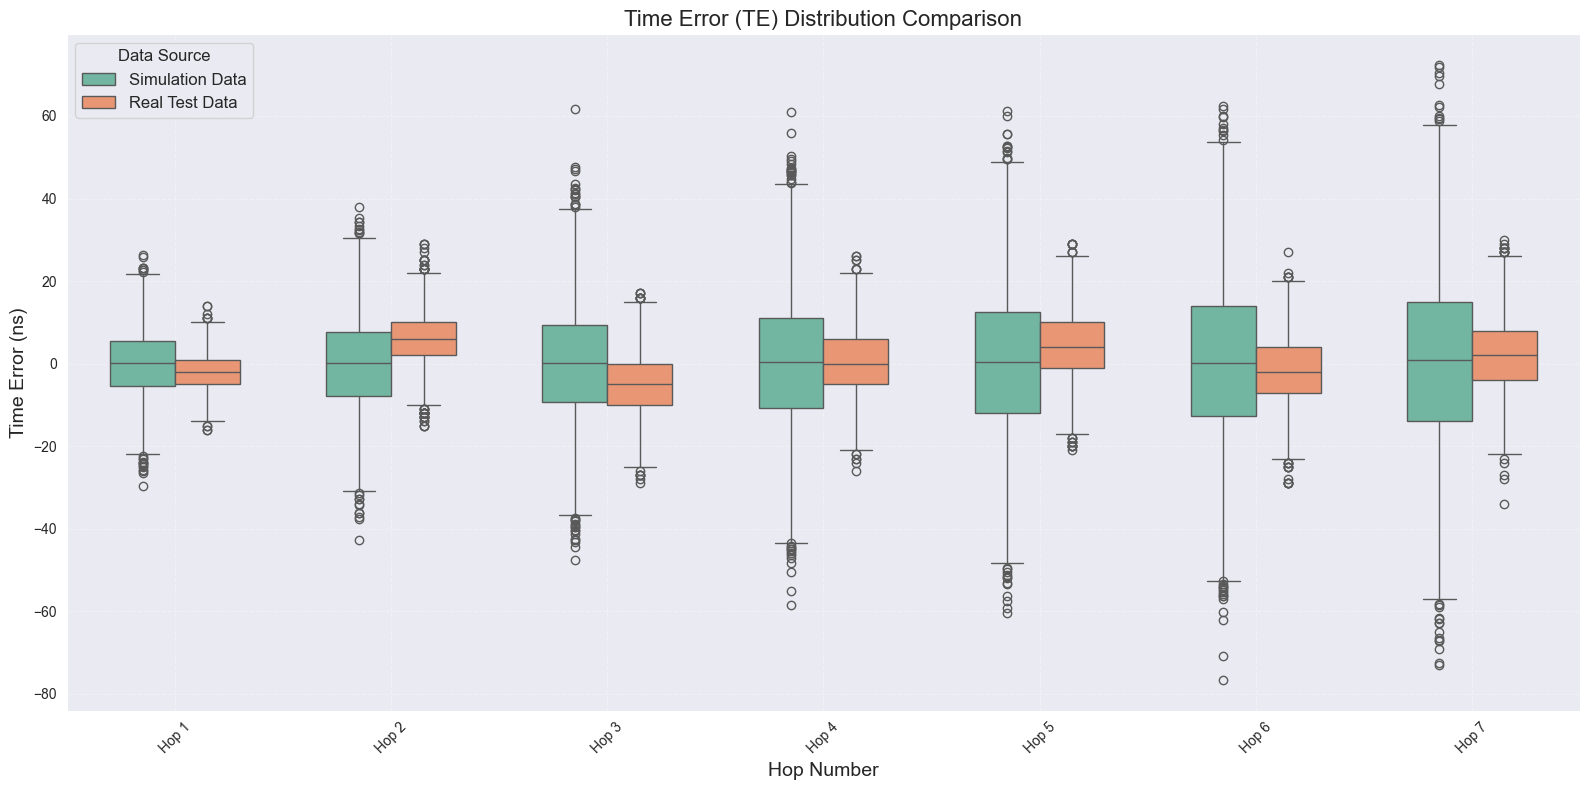

Comparison boxplot saved to output_image\te_comparison_boxplot.png
TE comparison boxplot analysis completed successfully!


In [13]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   绘制两组TE箱线图对比分析
*  @FileName:   te_boxplot_comparison.py
**************************************
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from typing import List, Dict

class TEBoxplotComparison:
    """两组时间误差(TE)箱线图对比分析类"""
    
    def __init__(self):
        """初始化分析类"""
        self.output_dir = 'output_image'
        os.makedirs(self.output_dir, exist_ok=True)
        
    def load_and_combine_data(self) -> Dict[str, pd.DataFrame]:
        """加载并组合两组数据"""
        print("Loading and combining data...")
        
        # 第一组数据: Simulation Data
        sim_1_7 = pd.read_csv(r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250506\output_data_test\data_simulation_1-7hops.csv")
        # sim_32 = pd.read_csv(r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_hop_32.csv")
        
        # 重命名列名并组合
        sim_data = sim_1_7.rename(columns={
            f'Hop_{i}': f'Hop {i}' for i in range(1, 8)
        })
        # sim_data['Hop 32'] = sim_32['simulation_data']
        
        # 第二组数据: Real Test Data
        real_1_7 = pd.read_csv(r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv")
        # real_32 = pd.read_csv(r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_hop_32.csv")
        
        # 重命名列名并组合
        real_data = real_1_7.rename(columns={
            f'TSN{i}': f'Hop {i}' for i in range(1, 8)
        })
        # real_data['Hop 32'] = real_32['real_data']
        
        return {
            "Simulation Data": sim_data,
            "Real Test Data": real_data
        }
    
    def plot_comparison_boxplot(self, data_dict: Dict[str, pd.DataFrame]):
        """
        绘制两组数据的对比箱线图
        
        参数:
            data_dict (Dict[str, pd.DataFrame]): 包含两组数据的字典
        """
        plt.figure(figsize=(16, 8))
        
        # 准备绘图数据 - 将两组数据合并并添加group列
        plot_data = []
        for group_name, df in data_dict.items():
            melted = df.melt(var_name='Hop', value_name='TE Value')
            melted['Group'] = group_name
            plot_data.append(melted)
            
        plot_data = pd.concat(plot_data)
        
        # 使用seaborn绘制箱线图
        boxplot = sns.boxplot(
            x='Hop', 
            y='TE Value', 
            hue='Group', 
            data=plot_data,
            palette="Set2",
            width=0.6
        )
        
        # 设置图形标题和标签
        plt.title('Time Error (TE) Distribution Comparison', fontsize=16)
        plt.xlabel('Hop Number', fontsize=14)
        plt.ylabel('Time Error (ns)', fontsize=14)
        
        # 添加参考线
        # plt.axhline(y=1000, color='r', linestyle='--', alpha=0.5, label='1μs Threshold')
        # plt.axhline(y=-1000, color='r', linestyle='--', alpha=0.5)
        
        # 调整x轴标签旋转角度
        plt.xticks(rotation=45)
        
        # 添加网格线
        plt.grid(True, linestyle='--', alpha=0.3)
        
        # 调整图例位置和样式
        plt.legend(title='Data Source', fontsize=12, title_fontsize=12)
        
        # 调整布局
        plt.tight_layout()
        
        # 显示并保存图像
        
        output_path = os.path.join(self.output_dir, 'te_comparison_boxplot.png')
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Comparison boxplot saved to {output_path}")
        
        plt.close()
    
    def run_analysis(self):
        """运行完整分析流程"""
        try:
            # 1. 加载并组合数据
            data_dict = self.load_and_combine_data()
            
            # 2. 绘制对比箱线图
            self.plot_comparison_boxplot(data_dict)
            
            print("TE comparison boxplot analysis completed successfully!")
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            raise

# 主函数
def main():
    # 创建分析实例并运行
    analyzer = TEBoxplotComparison()
    analyzer.run_analysis()

if __name__ == "__main__":
    main()


# 5、计算实测数据TDEV

数据加载成功！前5行示例：
   TSN1  TSN2  TSN3  TSN4  TSN5  TSN6  TSN7
0    -8    -8     5     4     2   -19     2
1     5   -12    -6     4     5   -13    -8
2     4    -8    -7     6    -2   -12     1
3    -3    -4    -8    -6     2     5     2
4    -3    -2     1    -8    -9    -1     6
数据将保存到: output_data
图片将保存到: output_image

处理 TSN1: 有效数据点=3600

处理 TSN2: 有效数据点=3600

处理 TSN3: 有效数据点=3600

处理 TSN4: 有效数据点=3600

处理 TSN5: 有效数据点=3600

处理 TSN6: 有效数据点=3600

处理 TSN7: 有效数据点=3600

所有TDEV数据已保存到: output_data\all_tdev_results_real.csv


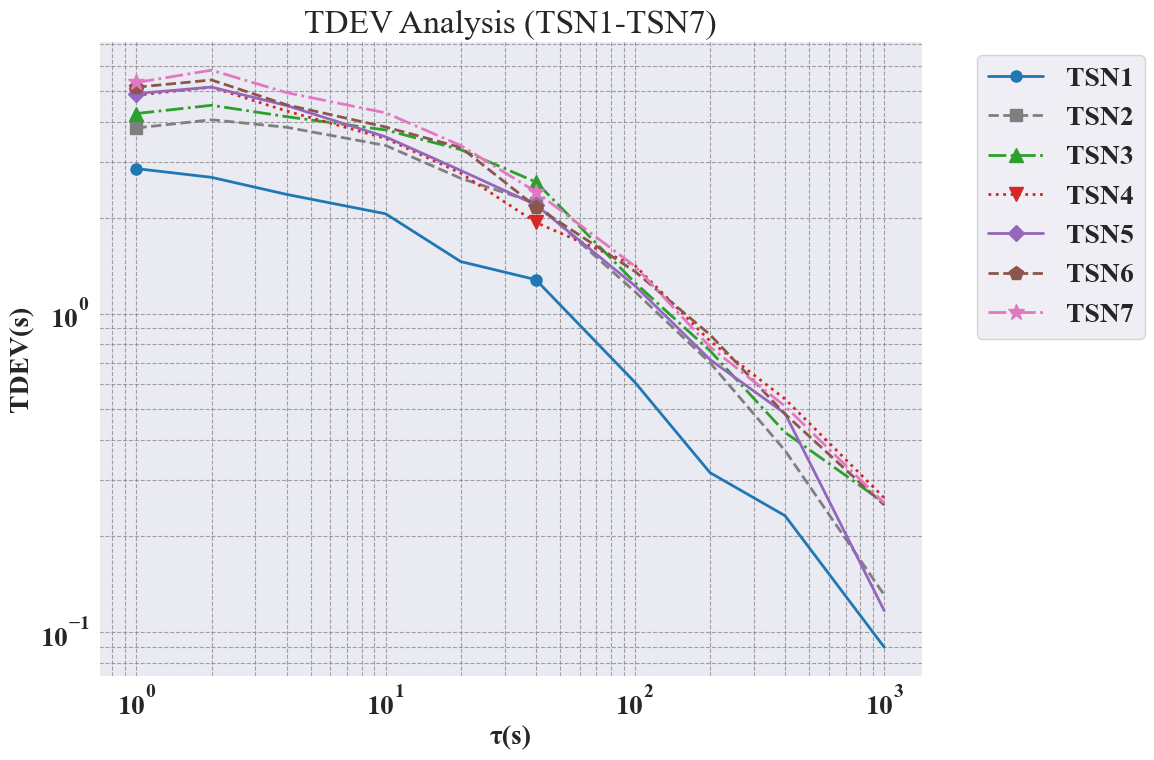

组合TDEV图已保存到: output_image\combined_tdev_plot_real.png

所有处理完成！


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件 - 修改为新的列名格式
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv"  # 替换为您的实际文件路径
try:
    df = pd.read_csv(file_path)
    # 检查列名是否是TSN1-TSN7格式，如果不是则尝试自动识别
    if not all(f'TSN{i}' in df.columns for i in range(1, 8)):
        # 尝试查找包含"TSN"的列
        tsn_cols = [col for col in df.columns if 'TSN' in col]
        if len(tsn_cols) >= 7:
            print(f"检测到TSN列: {tsn_cols[:7]}，将使用前7个TSN列")
        else:
            raise ValueError("CSV文件中未找到足够的TSN列(需要TSN1-TSN7)")
    
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数（保持不变）
def preprocess_data(hop_data):
    time_errors = hop_data.values
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录（保持不变）
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame（保持不变）
all_tdev_results = pd.DataFrame()
hop_columns = [f"TSN{i}" for i in range(1, 8)]  # 修改为TSN1-TSN7

# 5. 创建组合图（保持不变）
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式（保持不变）
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 10, 10, 8, 10, 12]

# 6. 遍历每一跳（修改列名引用）
for idx, hop_col in enumerate(hop_columns):
    try:
        # 处理数据
        if hop_col not in df.columns:
            # 尝试查找最接近的列名（不区分大小写）
            matching_cols = [col for col in df.columns if hop_col.lower() in col.lower()]
            if matching_cols:
                hop_col = matching_cols[0]
                print(f"注意: 使用 {hop_col} 代替 {hop_columns[idx]}")
            else:
                raise ValueError(f"列 {hop_col} 不存在")
                
        hop_data = df[hop_col]
        time_errors, fs = preprocess_data(hop_data)
        print(f"\n处理 {hop_col}: 有效数据点={len(time_errors)}")

        # 计算TDEV
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus="decade"
        )

        # 存储结果
        all_tdev_results[f"tau_{hop_col}"] = taus
        all_tdev_results[f"tdev_{hop_col}"] = tdev

        # 绘制到组合图中（修改标签显示）
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=5,
                 linewidth=2,
                 label=hop_col)  # 直接使用列名作为标签

    except Exception as e:
        print(f"处理 {hop_col} 时出错: {e}")
        continue

# 7. 保存所有TDEV结果到CSV（保持不变）
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_real.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据已保存到: {output_csv_path}")

# 8. 完善并保存组合图（修改标题）
ax.set_xlabel('τ(s)')
ax.set_ylabel('TDEV(s)')
ax.set_title('TDEV Analysis (TSN1-TSN7)')  # 修改标题
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图（修改输出文件名）
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_real.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图已保存到: {output_plot_path}")

print("\n所有处理完成！")


### 注意修改窗口 

```
2^n < M/3
```

数据加载成功！前5行示例：
   TSN1  TSN2  TSN3  TSN4  TSN5  TSN6  TSN7
0    -8    -8     5     4     2   -19     2
1     5   -12    -6     4     5   -13    -8
2     4    -8    -7     6    -2   -12     1
3    -3    -4    -8    -6     2     5     2
4    -3    -2     1    -8    -9    -1     6
数据将保存到: output_data
图片将保存到: output_image

处理 TSN1: 有效数据点=3600

处理 TSN2: 有效数据点=3600

处理 TSN3: 有效数据点=3600

处理 TSN4: 有效数据点=3600

处理 TSN5: 有效数据点=3600

处理 TSN6: 有效数据点=3600

处理 TSN7: 有效数据点=3600

所有TDEV数据已保存到: output_data\all_tdev_results_real.csv


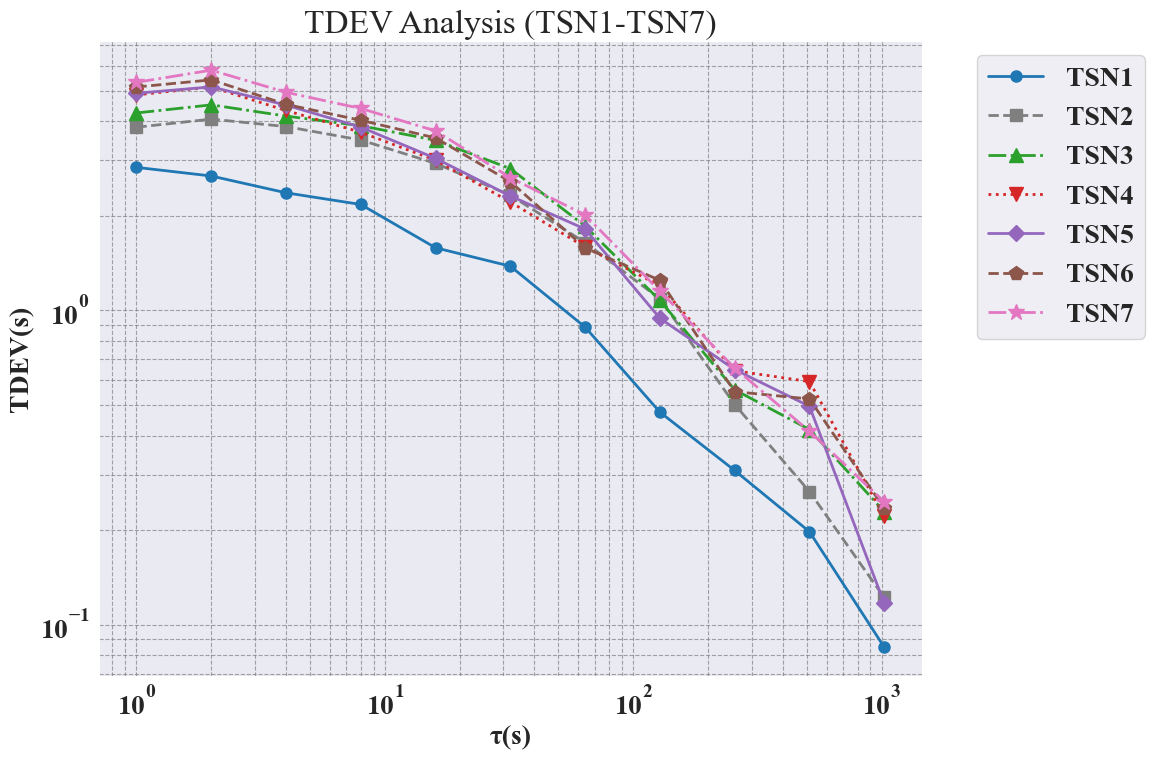

组合TDEV图已保存到: output_image\combined_tdev_plot_real.png

所有处理完成！


In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv"  # 替换为您的实际文件路径
try:
    df = pd.read_csv(file_path)
    # 检查列名是否是TSN1-TSN7格式，如果不是则尝试自动识别
    if not all(f'TSN{i}' in df.columns for i in range(1, 8)):
        # 尝试查找包含"TSN"的列
        tsn_cols = [col for col in df.columns if 'TSN' in col]
        if len(tsn_cols) >= 7:
            print(f"检测到TSN列: {tsn_cols[:7]}，将使用前7个TSN列")
        else:
            raise ValueError("CSV文件中未找到足够的TSN列(需要TSN1-TSN7)")
    
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数
def preprocess_data(hop_data):
    time_errors = hop_data.values
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame（初始化为空）
all_tdev_results = pd.DataFrame()
hop_columns = [f"TSN{i}" for i in range(1, 8)]  # TSN1-TSN7

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 10, 10, 8, 10, 12]

# 6. 遍历每一跳
for idx, hop_col in enumerate(hop_columns):
    try:
        # 处理数据
        if hop_col not in df.columns:
            # 尝试查找最接近的列名（不区分大小写）
            matching_cols = [col for col in df.columns if hop_col.lower() in col.lower()]
            if matching_cols:
                hop_col = matching_cols[0]
                print(f"注意: 使用 {hop_col} 代替 {hop_columns[idx]}")
            else:
                raise ValueError(f"列 {hop_col} 不存在")
                
        hop_data = df[hop_col]
        time_errors, fs = preprocess_data(hop_data)
        print(f"\n处理 {hop_col}: 有效数据点={len(time_errors)}")

        # 计算自定义的tau数组 [2^0, 2^1, ..., 2^n < 1800]
        max_tau = len(time_errors) // 2  # 3600/2 = 1800
        custom_taus = []
        n = 0
        while True:
            current_tau = 2 ** n
            if current_tau >= max_tau:
                break
            custom_taus.append(current_tau)
            n += 1
        
        # 计算TDEV使用自定义的taus
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus=custom_taus  # 使用自定义的tau数组
        )

        # 存储结果（动态扩展DataFrame）
        temp_df = pd.DataFrame({
            f"tau_{hop_col}": taus,
            f"tdev_{hop_col}": tdev
        })
        
        if all_tdev_results.empty:
            all_tdev_results = temp_df
        else:
            all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

        # 绘制到组合图中
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=1,  # 确保所有点都标记
                 linewidth=2,
                 label=hop_col)

    except Exception as e:
        print(f"处理 {hop_col} 时出错: {e}")
        continue

# 7. 保存所有TDEV结果到CSV
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_real.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据已保存到: {output_csv_path}")

# 8. 完善并保存组合图
ax.set_xlabel('τ(s)')
ax.set_ylabel('TDEV(s)')
ax.set_title('TDEV Analysis (TSN1-TSN7)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_real.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图已保存到: {output_plot_path}")

print("\n所有处理完成！")


数据加载成功！前5行示例：
   TSN1  TSN2  TSN3  TSN4  TSN5  TSN6  TSN7
0    -8    -8     5     4     2   -19     2
1     5   -12    -6     4     5   -13    -8
2     4    -8    -7     6    -2   -12     1
3    -3    -4    -8    -6     2     5     2
4    -3    -2     1    -8    -9    -1     6
数据将保存到: output_data
图片将保存到: output_image

处理 TSN1: 有效数据点=3600

处理 TSN2: 有效数据点=3600

处理 TSN3: 有效数据点=3600

处理 TSN4: 有效数据点=3600

处理 TSN5: 有效数据点=3600

处理 TSN6: 有效数据点=3600

处理 TSN7: 有效数据点=3600

所有TDEV数据（秒单位）已保存到: output_data\all_tdev_results_real_seconds.csv


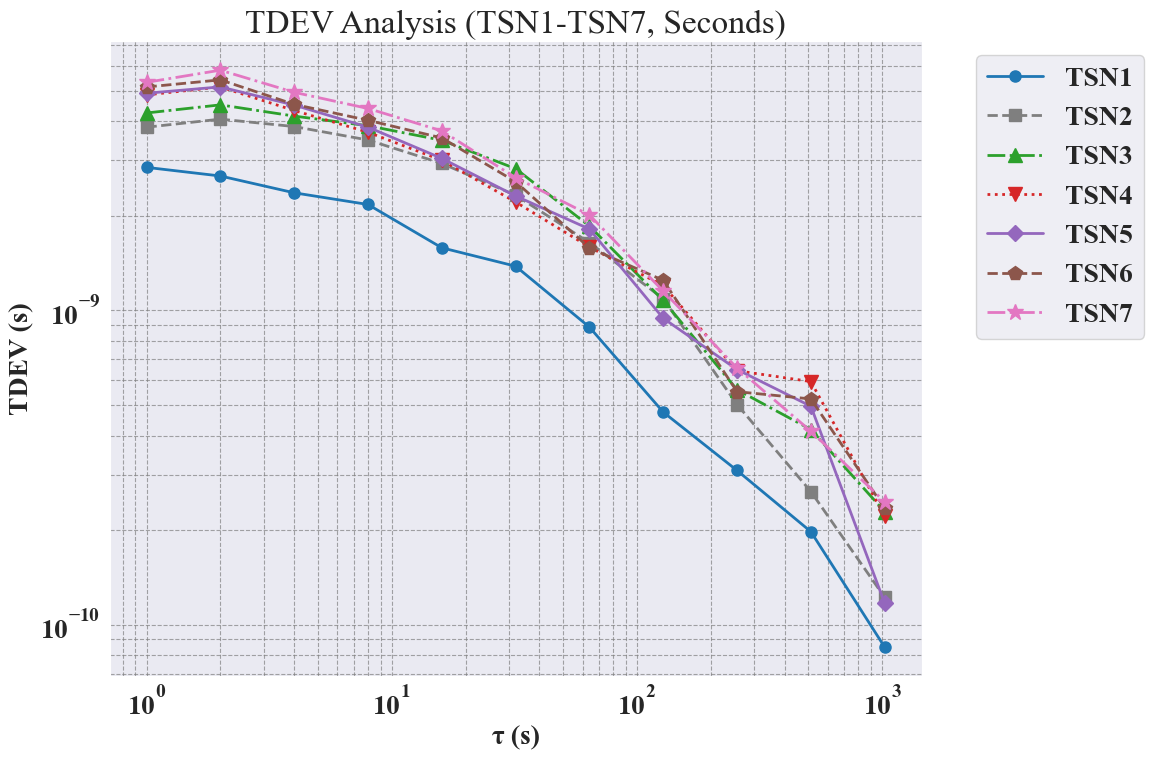

组合TDEV图（秒单位）已保存到: output_image\combined_tdev_plot_real_seconds.png

所有处理完成！


In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv"  # 替换为实际路径
try:
    df = pd.read_csv(file_path)
    # 检查列名是否是TSN1-TSN7格式，如果不是则尝试自动识别
    if not all(f'TSN{i}' in df.columns for i in range(1, 8)):
        tsn_cols = [col for col in df.columns if 'TSN' in col]
        if len(tsn_cols) >= 7:
            print(f"检测到TSN列: {tsn_cols[:7]}，将使用前7个TSN列")
        else:
            raise ValueError("CSV文件中未找到足够的TSN列(需要TSN1-TSN7)")
    
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数（新增纳秒转秒）
def preprocess_data(hop_data):
    time_errors_ns = hop_data.values  # 原始数据单位：纳秒
    time_errors = time_errors_ns / 1e9  # 转换为秒
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储TDEV结果的DataFrame（动态扩展）
all_tdev_results = pd.DataFrame()
hop_columns = [f"TSN{i}" for i in range(1, 8)]  # TSN1-TSN7

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 10, 10, 8, 10, 12]

# 6. 遍历每一跳
for idx, hop_col in enumerate(hop_columns):
    try:
        # 处理数据
        if hop_col not in df.columns:
            matching_cols = [col for col in df.columns if hop_col.lower() in col.lower()]
            if matching_cols:
                hop_col = matching_cols[0]
                print(f"注意: 使用 {hop_col} 代替 {hop_columns[idx]}")
            else:
                raise ValueError(f"列 {hop_col} 不存在")
                
        hop_data = df[hop_col]
        time_errors, fs = preprocess_data(hop_data)  # 单位已转换为秒
        print(f"\n处理 {hop_col}: 有效数据点={len(time_errors)}")

        # 计算自定义tau数组 [2^0, 2^1, ..., 2^n < 1800]
        max_tau = len(time_errors) // 2  # 3600/2 = 1800
        custom_taus = []
        n = 0
        while True:
            current_tau = 2 ** n
            if current_tau >= max_tau:
                break
            custom_taus.append(current_tau)
            n += 1
        
        # 计算TDEV（单位：秒）
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus=custom_taus
        )

        # 存储结果
        temp_df = pd.DataFrame({
            f"tau_{hop_col}": taus,
            f"tdev_{hop_col}": tdev
        })
        
        if all_tdev_results.empty:
            all_tdev_results = temp_df
        else:
            all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

        # 绘制曲线（单位：秒）
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=1,
                 linewidth=2,
                 label=hop_col)

    except Exception as e:
        print(f"处理 {hop_col} 时出错: {e}")
        continue

# 7. 保存TDEV结果到CSV（单位：秒）
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_real_seconds.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据（秒单位）已保存到: {output_csv_path}")

# 8. 完善并保存组合图
ax.set_xlabel('τ (s)')
ax.set_ylabel('TDEV (s)')  # 单位标注为秒
ax.set_title('TDEV Analysis (TSN1-TSN7, Seconds)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_real_seconds.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图（秒单位）已保存到: {output_plot_path}")

print("\n所有处理完成！")


# 6、计算仿真数据TDEV


数据加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6      Hop_7
0  10.421572   9.344581  20.635331  12.992444  30.573348  34.119284  27.929507
1  -8.351021   1.387872  -7.420092 -15.459032 -23.887676 -10.842700 -14.714709
2  -1.686775 -16.718110 -19.176460 -28.284148 -15.298245 -12.498138 -13.285438
3  -5.848896 -20.235402 -16.515210 -24.157374 -23.944353 -16.126936 -31.559420
4  11.706508  25.173347  42.146717  41.199638  45.479436  46.964899  56.529203
数据将保存到: output_data
图片将保存到: output_image

处理 Hop_1: 有效数据点=3600

处理 Hop_2: 有效数据点=3600

处理 Hop_3: 有效数据点=3600

处理 Hop_4: 有效数据点=3600

处理 Hop_5: 有效数据点=3600

处理 Hop_6: 有效数据点=3600

处理 Hop_7: 有效数据点=3600

所有TDEV数据已保存到: output_data\all_tdev_results_simulation.csv


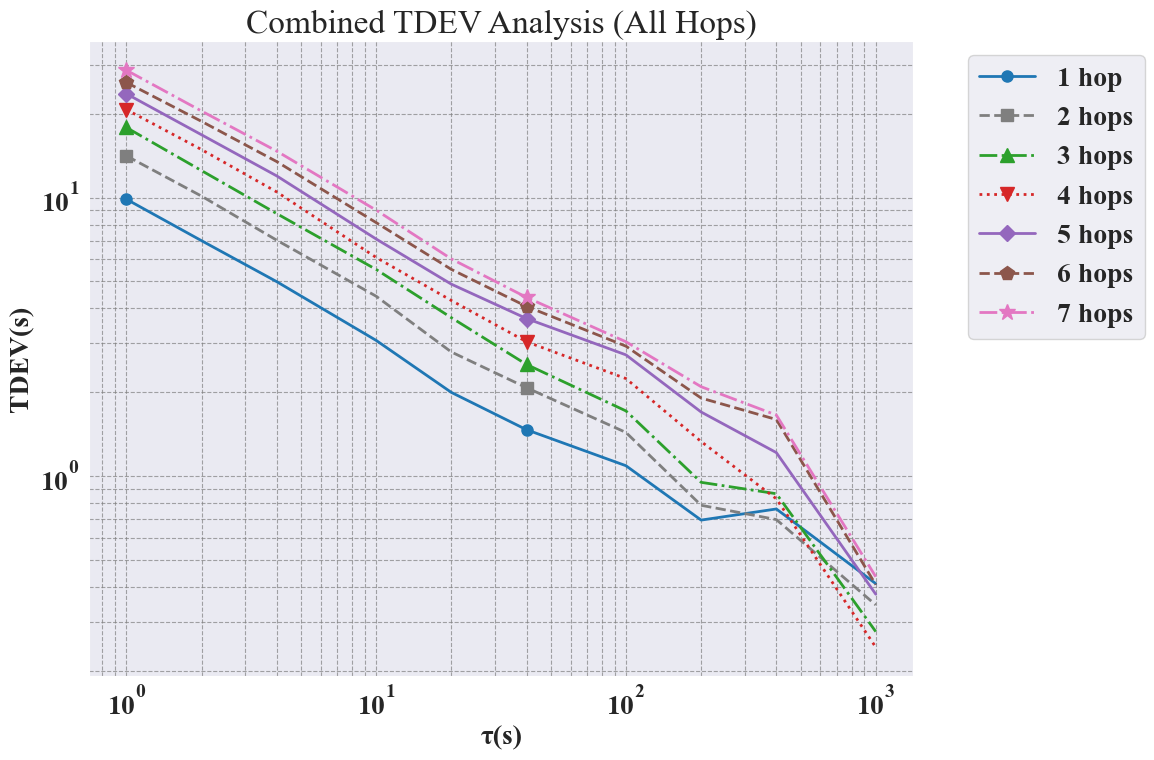

组合TDEV图已保存到: output_image\combined_tdev_plot_simulation.png

所有处理完成！


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_simulation_1-7hops.csv"
try:
    df = pd.read_csv(file_path)
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数
def preprocess_data(hop_data):
    time_errors = hop_data.values
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame
all_tdev_results = pd.DataFrame()
hop_columns = [f"Hop_{i}" for i in range(1, 8)]  # 列名列表

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 10, 10, 8, 10, 12]

# 6. 遍历每一跳
for idx, hop_col in enumerate(hop_columns):
    try:
        # 处理数据
        hop_data = df[hop_col]
        time_errors, fs = preprocess_data(hop_data)
        print(f"\n处理 {hop_col}: 有效数据点={len(time_errors)}")

        # 计算TDEV
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus="decade"
        )

        # 存储结果
        all_tdev_results[f"tau_{hop_col}"] = taus
        all_tdev_results[f"tdev_{hop_col}"] = tdev

        # 绘制到组合图中
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=5,
                 linewidth=2,
                 label=f'{idx+1} hop{"s" if idx+1>1 else ""}')

    except Exception as e:
        print(f"处理 {hop_col} 时出错: {e}")
        continue

# 7. 保存所有TDEV结果到CSV
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_simulation.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据已保存到: {output_csv_path}")

# 8. 完善并保存组合图
ax.set_xlabel('τ(s)')
ax.set_ylabel('TDEV(s)')
ax.set_title('Combined TDEV Analysis (All Hops)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_simulation.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图已保存到: {output_plot_path}")

print("\n所有处理完成！")


### 修改窗口大小

数据加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6      Hop_7
0   9.795855  11.668800  -0.756927   3.050530   6.387847  10.395577   9.279935
1 -13.103482 -27.172342 -26.254566 -21.949902 -21.540446 -28.388111 -35.865747
2  -1.854366  -1.012677   6.484777  -0.351086  -7.195648   5.535059   7.760046
3  -1.122407  11.716159   3.597308  14.700923  17.947929  31.660563  41.871756
4   0.700513   7.016926  23.671973  23.029628  31.974754  20.610048  31.490623
数据将保存到: output_data
图片将保存到: output_image

处理 Hop_1: 有效数据点=3600

处理 Hop_2: 有效数据点=3600

处理 Hop_3: 有效数据点=3600

处理 Hop_4: 有效数据点=3600

处理 Hop_5: 有效数据点=3600

处理 Hop_6: 有效数据点=3600

处理 Hop_7: 有效数据点=3600

所有TDEV数据（秒单位）已保存到: output_data\all_tdev_results_simulation_seconds.csv


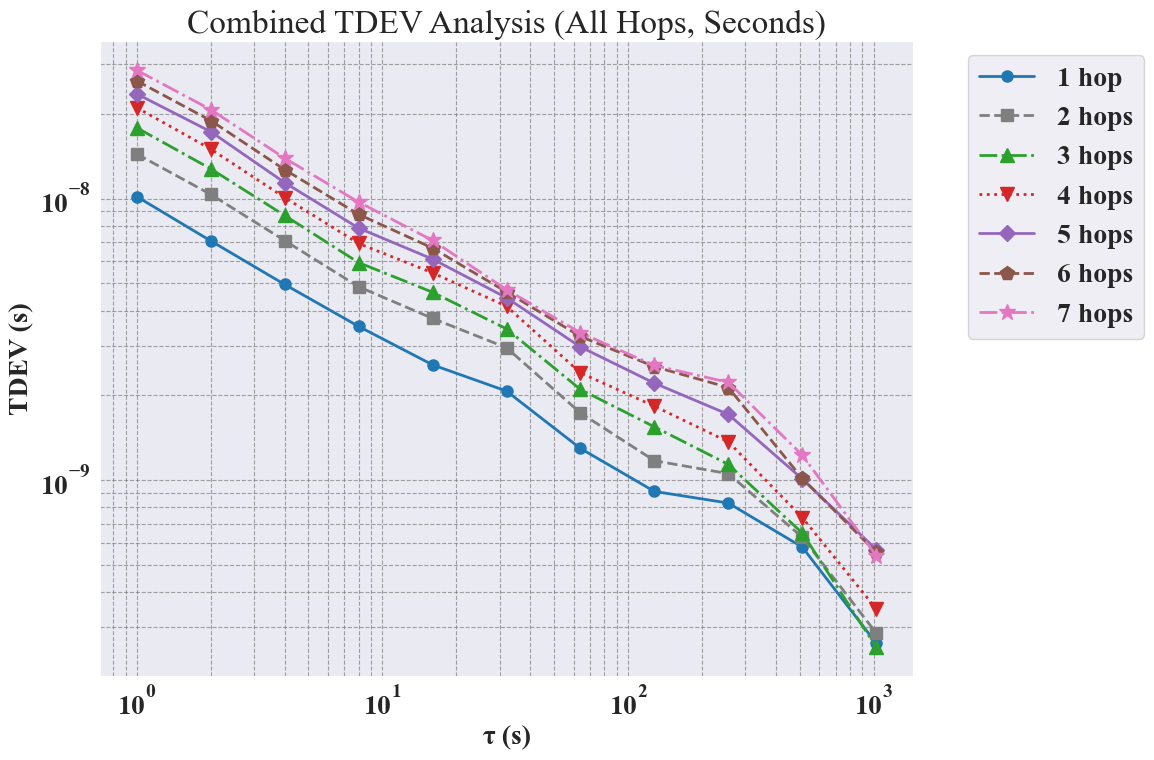

组合TDEV图（秒单位）已保存到: output_image\combined_tdev_plot_simulation_seconds.png

所有处理完成！


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 加载CSV文件
file_path = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_simulation_1-7hops.csv"
try:
    df = pd.read_csv(file_path)
    print("数据加载成功！前5行示例：")
    print(df.head())
except Exception as e:
    print(f"文件加载失败: {e}")
    exit()

# 2. 数据预处理函数（新增纳秒转秒）
def preprocess_data(hop_data):
    time_errors_ns = hop_data.values  # 原始数据单位：纳秒
    time_errors = time_errors_ns / 1e9  # 转换为秒
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame（动态扩展）
all_tdev_results = pd.DataFrame()
hop_columns = [f"Hop_{i}" for i in range(1, 8)]  # 列名列表

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
linestyles = ['-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 10, 10, 8, 10, 12]

# 6. 遍历每一跳
for idx, hop_col in enumerate(hop_columns):
    try:
        # 处理数据
        hop_data = df[hop_col]
        time_errors, fs = preprocess_data(hop_data)
        print(f"\n处理 {hop_col}: 有效数据点={len(time_errors)}")

        # 计算自定义tau数组 [2^0, 2^1, ..., 2^n < 1800]
        max_tau = len(time_errors) // 2  # 3600/2 = 1800
        custom_taus = []
        n = 0
        while True:
            current_tau = 2 ** n
            if current_tau >= max_tau:
                break
            custom_taus.append(current_tau)
            n += 1
        
        # 计算TDEV（单位：秒）
        taus, tdev, _, _ = allantools.tdev(
            data=time_errors,
            rate=fs,
            data_type="phase",
            taus=custom_taus  # 使用自定义tau数组
        )

        # 动态存储结果
        temp_df = pd.DataFrame({
            f"tau_{hop_col}": taus,
            f"tdev_{hop_col}": tdev
        })
        
        if all_tdev_results.empty:
            all_tdev_results = temp_df
        else:
            all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

        # 绘制到组合图中
        ax.loglog(taus, tdev, 
                 color=colors[idx], 
                 linestyle=linestyles[idx],
                 marker=markers[idx],
                 markersize=marker_sizes[idx],
                 markevery=1,  # 确保所有点都标记
                 linewidth=2,
                 label=f'{idx+1} hop{"s" if idx+1>1 else ""}')

    except Exception as e:
        print(f"处理 {hop_col} 时出错: {e}")
        continue

# 7. 保存所有TDEV结果到CSV（单位：秒）
output_csv_path = os.path.join(output_data_dir, "all_tdev_results_simulation_seconds.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据（秒单位）已保存到: {output_csv_path}")

# 8. 完善并保存组合图
ax.set_xlabel('τ (s)')
ax.set_ylabel('TDEV (s)')  # 单位标注为秒
ax.set_title('Combined TDEV Analysis (All Hops, Seconds)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_simulation_seconds.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图（秒单位）已保存到: {output_plot_path}")

print("\n所有处理完成！")


 # 7、画出1-7、32跳实测+仿真数据TDEV曲线图

# 7.1 合并1-7的tdev 在一张图里面

数据将保存到: output_data
图片将保存到: output_image

仿真数据加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6      Hop_7
0   9.795855  11.668800  -0.756927   3.050530   6.387847  10.395577   9.279935
1 -13.103482 -27.172342 -26.254566 -21.949902 -21.540446 -28.388111 -35.865747
2  -1.854366  -1.012677   6.484777  -0.351086  -7.195648   5.535059   7.760046
3  -1.122407  11.716159   3.597308  14.700923  17.947929  31.660563  41.871756
4   0.700513   7.016926  23.671973  23.029628  31.974754  20.610048  31.490623

处理仿真数据 Hop_1: 有效数据点=3600

处理仿真数据 Hop_2: 有效数据点=3600

处理仿真数据 Hop_3: 有效数据点=3600

处理仿真数据 Hop_4: 有效数据点=3600

处理仿真数据 Hop_5: 有效数据点=3600

处理仿真数据 Hop_6: 有效数据点=3600

处理仿真数据 Hop_7: 有效数据点=3600

实测数据加载成功！前5行示例：
   TSN1  TSN2  TSN3  TSN4  TSN5  TSN6  TSN7
0    -8    -8     5     4     2   -19     2
1     5   -12    -6     4     5   -13    -8
2     4    -8    -7     6    -2   -12     1
3    -3    -4    -8    -6     2     5     2
4    -3    -2     1    -8    -9    -1     6

处理实测

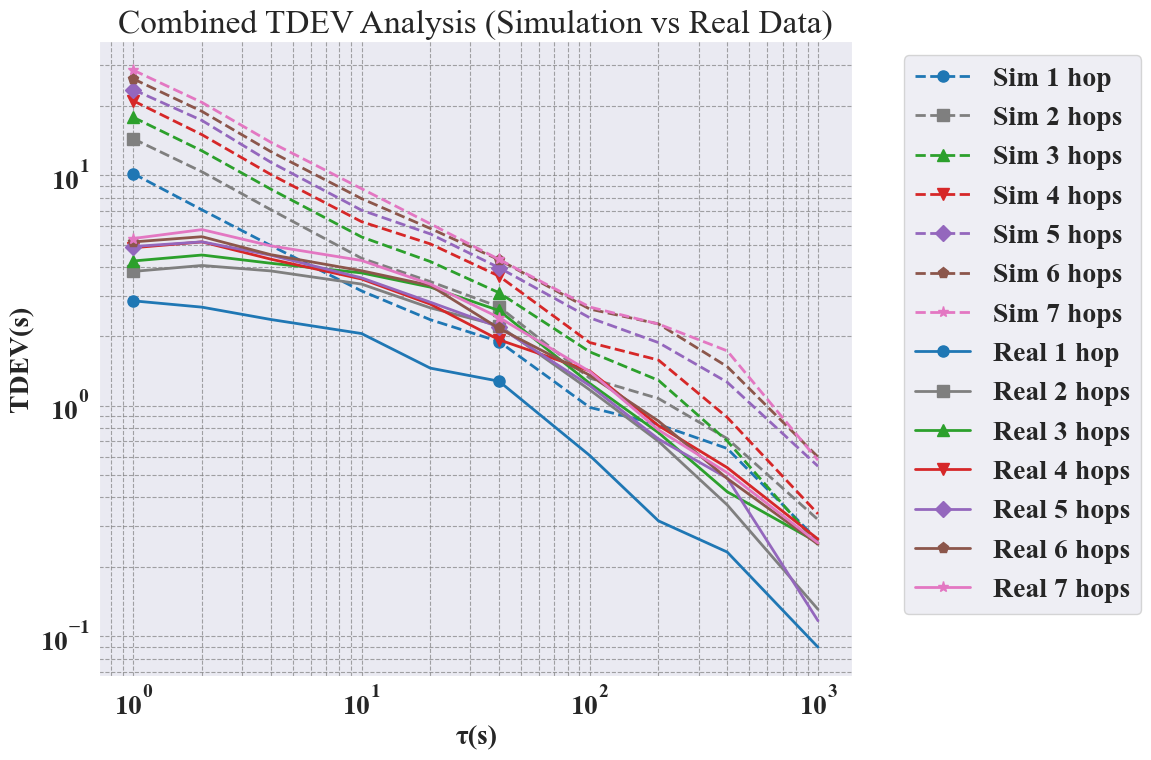

组合TDEV图已保存到: output_image\combined_tdev_plot_simulation+real_1-7hops.png

所有处理完成！


In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 定义文件路径
simulation_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_simulation_1-7hops.csv"
real_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv"

# 2. 数据预处理函数
def preprocess_data(hop_data):
    time_errors = hop_data.values
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame
all_tdev_results = pd.DataFrame()

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 8, 8, 8, 8, 8]

# 6. 处理仿真数据
try:
    df_sim = pd.read_csv(simulation_file)
    print("\n仿真数据加载成功！前5行示例：")
    print(df_sim.head())
    
    sim_hop_columns = [f"Hop_{i}" for i in range(1, 8)]
    
    for idx, hop_col in enumerate(sim_hop_columns):
        try:
            # 处理数据
            hop_data = df_sim[hop_col]
            time_errors, fs = preprocess_data(hop_data)
            print(f"\n处理仿真数据 {hop_col}: 有效数据点={len(time_errors)}")

            # 计算TDEV
            taus, tdev, _, _ = allantools.tdev(
                data=time_errors,
                rate=fs,
                data_type="phase",
                taus="decade"
            )

            # 存储结果
            all_tdev_results[f"tau_sim_{idx+1}hop"] = taus
            all_tdev_results[f"tdev_sim_{idx+1}hop"] = tdev

            # 绘制到组合图中 - 使用虚线
            ax.loglog(taus, tdev, 
                     color=colors[idx], 
                     linestyle='--',  # 仿真数据用虚线
                     marker=markers[idx],
                     markersize=marker_sizes[idx],
                     markevery=5,
                     linewidth=2,
                     label=f'Sim {idx+1} hop{"s" if idx+1>1 else ""}')

        except Exception as e:
            print(f"处理仿真数据 {hop_col} 时出错: {e}")
            continue
            
except Exception as e:
    print(f"\n仿真数据文件加载失败: {e}")

# 7. 处理实测数据
try:
    df_real = pd.read_csv(real_file)
    print("\n实测数据加载成功！前5行示例：")
    print(df_real.head())
    
    # 检查列名是否是TSN1-TSN7格式，如果不是则尝试自动识别
    real_hop_columns = []
    if all(f'TSN{i}' in df_real.columns for i in range(1, 8)):
        real_hop_columns = [f"TSN{i}" for i in range(1, 8)]
    else:
        # 尝试查找包含"TSN"的列
        tsn_cols = [col for col in df_real.columns if 'TSN' in col]
        if len(tsn_cols) >= 7:
            real_hop_columns = tsn_cols[:7]
            print(f"检测到TSN列: {real_hop_columns}，将使用前7个TSN列")
        else:
            raise ValueError("CSV文件中未找到足够的TSN列(需要TSN1-TSN7)")
    
    for idx, hop_col in enumerate(real_hop_columns):
        try:
            # 处理数据
            if hop_col not in df_real.columns:
                # 尝试查找最接近的列名（不区分大小写）
                matching_cols = [col for col in df_real.columns if hop_col.lower() in col.lower()]
                if matching_cols:
                    hop_col = matching_cols[0]
                    print(f"注意: 使用 {hop_col} 代替 {real_hop_columns[idx]}")
                else:
                    raise ValueError(f"列 {hop_col} 不存在")
                    
            hop_data = df_real[hop_col]
            time_errors, fs = preprocess_data(hop_data)
            print(f"\n处理实测数据 {hop_col}: 有效数据点={len(time_errors)}")

            # 计算TDEV
            taus, tdev, _, _ = allantools.tdev(
                data=time_errors,
                rate=fs,
                data_type="phase",
                taus="decade"
            )

            # 存储结果
            all_tdev_results[f"tau_real_{idx+1}hop"] = taus
            all_tdev_results[f"tdev_real_{idx+1}hop"] = tdev

            # 绘制到组合图中 - 使用实线
            ax.loglog(taus, tdev, 
                     color=colors[idx], 
                     linestyle='-',  # 实测数据用实线
                     marker=markers[idx],
                     markersize=marker_sizes[idx],
                     markevery=5,
                     linewidth=2,
                     label=f'Real {idx+1} hop{"s" if idx+1>1 else ""}')

        except Exception as e:
            print(f"处理实测数据 {hop_col} 时出错: {e}")
            continue
            
except Exception as e:
    print(f"\n实测数据文件加载失败: {e}")

# 8. 保存所有TDEV结果到CSV
output_csv_path = os.path.join(output_data_dir, "combined_tdev_results_simulation+real_1-7hops.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据已合并保存到: {output_csv_path}")

# 9. 完善并保存组合图
ax.set_xlabel('τ(s)')
ax.set_ylabel('TDEV(s)')
ax.set_title('Combined TDEV Analysis (Simulation vs Real Data)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_simulation+real_1-7hops.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图已保存到: {output_plot_path}")

print("\n所有处理完成！")


数据将保存到: output_data
图片将保存到: output_image

仿真数据加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6      Hop_7
0   9.795855  11.668800  -0.756927   3.050530   6.387847  10.395577   9.279935
1 -13.103482 -27.172342 -26.254566 -21.949902 -21.540446 -28.388111 -35.865747
2  -1.854366  -1.012677   6.484777  -0.351086  -7.195648   5.535059   7.760046
3  -1.122407  11.716159   3.597308  14.700923  17.947929  31.660563  41.871756
4   0.700513   7.016926  23.671973  23.029628  31.974754  20.610048  31.490623

处理仿真数据 Hop_1: 有效数据点=3600

处理仿真数据 Hop_2: 有效数据点=3600

处理仿真数据 Hop_3: 有效数据点=3600

处理仿真数据 Hop_4: 有效数据点=3600

处理仿真数据 Hop_5: 有效数据点=3600

处理仿真数据 Hop_6: 有效数据点=3600

处理仿真数据 Hop_7: 有效数据点=3600

实测数据加载成功！前5行示例：
   TSN1  TSN2  TSN3  TSN4  TSN5  TSN6  TSN7
0    -8    -8     5     4     2   -19     2
1     5   -12    -6     4     5   -13    -8
2     4    -8    -7     6    -2   -12     1
3    -3    -4    -8    -6     2     5     2
4    -3    -2     1    -8    -9    -1     6

处理实测

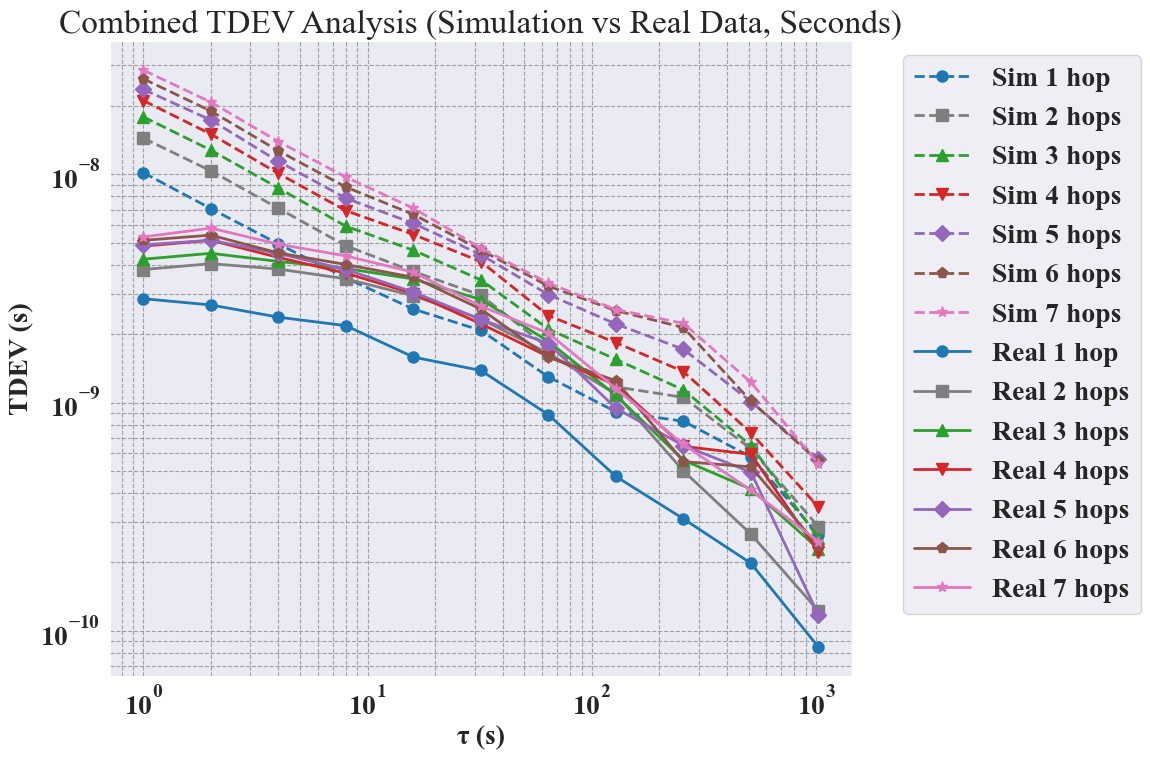

组合TDEV图（秒单位）已保存到: output_image\combined_tdev_plot_simulation+real_1-7hops_seconds.png

所有处理完成！


In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import allantools
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 定义文件路径
simulation_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_simulation_1-7hops.csv"
real_file = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\data_real_1-7hops.csv"

# 2. 数据预处理函数（新增纳秒转秒）
def preprocess_data(hop_data):
    time_errors_ns = hop_data.values  # 原始数据单位：纳秒
    time_errors = time_errors_ns / 1e9  # 转换为秒
    fs = 1  # 默认采样率1Hz

    if len(time_errors) < 10:
        raise ValueError("数据点不足（至少需要10个点）")
    if np.all(np.isnan(time_errors)):
        raise ValueError("时间误差数据全为NaN")

    time_errors = np.nan_to_num(time_errors, nan=np.nanmean(time_errors))
    return time_errors, fs

# 3. 创建输出目录
output_data_dir = "output_data"
output_image_dir = "output_image"
os.makedirs(output_data_dir, exist_ok=True)
os.makedirs(output_image_dir, exist_ok=True)
print(f"数据将保存到: {output_data_dir}")
print(f"图片将保存到: {output_image_dir}")

# 4. 准备存储所有TDEV结果的DataFrame（动态扩展）
all_tdev_results = pd.DataFrame()

# 5. 创建组合图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#7f7f7f', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
markers = ['o', 's', '^', 'v', 'D', 'p', '*']
marker_sizes = [8, 8, 8, 8, 8, 8, 8]

# 6. 处理仿真数据
try:
    df_sim = pd.read_csv(simulation_file)
    print("\n仿真数据加载成功！前5行示例：")
    print(df_sim.head())
    
    sim_hop_columns = [f"Hop_{i}" for i in range(1, 8)]
    
    for idx, hop_col in enumerate(sim_hop_columns):
        try:
            # 处理数据
            hop_data = df_sim[hop_col]
            time_errors, fs = preprocess_data(hop_data)
            print(f"\n处理仿真数据 {hop_col}: 有效数据点={len(time_errors)}")

            # 计算自定义tau数组 [2^0, 2^1, ..., 2^n < 1800]
            max_tau = len(time_errors) // 2  # 3600/2 = 1800
            custom_taus = []
            n = 0
            while True:
                current_tau = 2 ** n
                if current_tau >= max_tau:
                    break
                custom_taus.append(current_tau)
                n += 1
            
            # 计算TDEV（单位：秒）
            taus, tdev, _, _ = allantools.tdev(
                data=time_errors,
                rate=fs,
                data_type="phase",
                taus=custom_taus  # 使用自定义tau数组
            )

            # 动态存储结果
            temp_df = pd.DataFrame({
                f"tau_sim_{idx+1}hop": taus,
                f"tdev_sim_{idx+1}hop": tdev
            })
            
            if all_tdev_results.empty:
                all_tdev_results = temp_df
            else:
                all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

            # 绘制到组合图中 - 使用虚线
            ax.loglog(taus, tdev, 
                     color=colors[idx], 
                     linestyle='--',  # 仿真数据用虚线
                     marker=markers[idx],
                     markersize=marker_sizes[idx],
                     markevery=1,  # 确保所有点都标记
                     linewidth=2,
                     label=f'Sim {idx+1} hop{"s" if idx+1>1 else ""}')

        except Exception as e:
            print(f"处理仿真数据 {hop_col} 时出错: {e}")
            continue
            
except Exception as e:
    print(f"\n仿真数据文件加载失败: {e}")

# 7. 处理实测数据
try:
    df_real = pd.read_csv(real_file)
    print("\n实测数据加载成功！前5行示例：")
    print(df_real.head())
    
    # 检查列名是否是TSN1-TSN7格式，如果不是则尝试自动识别
    real_hop_columns = []
    if all(f'TSN{i}' in df_real.columns for i in range(1, 8)):
        real_hop_columns = [f"TSN{i}" for i in range(1, 8)]
    else:
        # 尝试查找包含"TSN"的列
        tsn_cols = [col for col in df_real.columns if 'TSN' in col]
        if len(tsn_cols) >= 7:
            real_hop_columns = tsn_cols[:7]
            print(f"检测到TSN列: {real_hop_columns}，将使用前7个TSN列")
        else:
            raise ValueError("CSV文件中未找到足够的TSN列(需要TSN1-TSN7)")
    
    for idx, hop_col in enumerate(real_hop_columns):
        try:
            # 处理数据
            if hop_col not in df_real.columns:
                # 尝试查找最接近的列名（不区分大小写）
                matching_cols = [col for col in df_real.columns if hop_col.lower() in col.lower()]
                if matching_cols:
                    hop_col = matching_cols[0]
                    print(f"注意: 使用 {hop_col} 代替 {real_hop_columns[idx]}")
                else:
                    raise ValueError(f"列 {hop_col} 不存在")
                    
            hop_data = df_real[hop_col]
            time_errors, fs = preprocess_data(hop_data)
            print(f"\n处理实测数据 {hop_col}: 有效数据点={len(time_errors)}")

            # 计算自定义tau数组 [2^0, 2^1, ..., 2^n < 1800]
            max_tau = len(time_errors) // 2  # 3600/2 = 1800
            custom_taus = []
            n = 0
            while True:
                current_tau = 2 ** n
                if current_tau >= max_tau:
                    break
                custom_taus.append(current_tau)
                n += 1
            
            # 计算TDEV（单位：秒）
            taus, tdev, _, _ = allantools.tdev(
                data=time_errors,
                rate=fs,
                data_type="phase",
                taus=custom_taus  # 使用自定义tau数组
            )

            # 动态存储结果
            temp_df = pd.DataFrame({
                f"tau_real_{idx+1}hop": taus,
                f"tdev_real_{idx+1}hop": tdev
            })
            
            if all_tdev_results.empty:
                all_tdev_results = temp_df
            else:
                all_tdev_results = pd.concat([all_tdev_results, temp_df], axis=1)

            # 绘制到组合图中 - 使用实线
            ax.loglog(taus, tdev, 
                     color=colors[idx], 
                     linestyle='-',  # 实测数据用实线
                     marker=markers[idx],
                     markersize=marker_sizes[idx],
                     markevery=1,  # 确保所有点都标记
                     linewidth=2,
                     label=f'Real {idx+1} hop{"s" if idx+1>1 else ""}')

        except Exception as e:
            print(f"处理实测数据 {hop_col} 时出错: {e}")
            continue
            
except Exception as e:
    print(f"\n实测数据文件加载失败: {e}")

# 8. 保存所有TDEV结果到CSV（单位：秒）
output_csv_path = os.path.join(output_data_dir, "combined_tdev_results_simulation+real_1-7hops_seconds.csv")
all_tdev_results.to_csv(output_csv_path, index=False)
print(f"\n所有TDEV数据（秒单位）已合并保存到: {output_csv_path}")

# 9. 完善并保存组合图
ax.set_xlabel('τ (s)')
ax.set_ylabel('TDEV (s)')  # 单位标注为秒
ax.set_title('Combined TDEV Analysis (Simulation vs Real Data, Seconds)')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()

# 保存组合图
output_plot_path = os.path.join(output_image_dir, "combined_tdev_plot_simulation+real_1-7hops_seconds.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"组合TDEV图（秒单位）已保存到: {output_plot_path}")

print("\n所有处理完成！")


# 8、计算时间误差绝对值最大值，并在word中添加表格

# 9、计算100跳和对应的仿真分域时间误差结果

# 10、 计算100跳和对应的仿真的分域结果的TDEV

# 11、 画100跳和分域结果的TDEV图（可以考虑子图）

# 12、尝试修改代码，增加propagation delay。

In [104]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算一百跳时间感知网络的时间误差
*  @FileName:   main_test_20250429.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Based on analysis of McCall et al. documents (2021-2022)

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import random
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性
    rr_drift_correction: float = 0.90  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops))  # 每次运行中每个跳的te
        }

        # 创建输出目录
        self.output_data_dir = 'output_data'
        self.output_image_dir = 'output_image'
        os.makedirs(self.output_data_dir, exist_ok=True)
        os.makedirs(self.output_image_dir, exist_ok=True)

    def generate_timestamp_error(self, is_tx: bool) -> float:
        """使用高斯分布而非均匀分布生成随机时间戳误差"""
        if is_tx:
            # 高斯分布，标准差为参数值的1/3
            # tsge = np.random.normal(0, self.params.tsge_tx/3)
            tsge = np.random.normal(0, self.params.tsge_tx)
            # dtse = np.random.normal(0, self.params.dtse_tx/3)
            dtse = np.random.normal(0, self.params.dtse_tx)
            # 限制极端值
            # tsge = np.clip(tsge, -self.params.tsge_tx, self.params.tsge_tx)
            # dtse = np.clip(dtse, -self.params.dtse_tx, self.params.dtse_tx)
        else:
            # 接收端同理
            tsge = np.random.normal(0, self.params.tsge_rx)
            # tsge = np.random.normal(0, self.params.tsge_rx/3)
            dtse = np.random.normal(0, self.params.dtse_rx)
            # dtse = np.random.normal(0, self.params.dtse_rx/3)
            # tsge = np.clip(tsge, -self.params.tsge_rx, self.params.tsge_rx)
            # dtse = np.clip(dtse, -self.params.dtse_rx, self.params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool) -> float:
        """根据参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= self.params.gm_clock_drift_fraction:
                return np.random.uniform(self.params.gm_clock_drift_min, self.params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= self.params.clock_drift_fraction:
                return np.random.uniform(self.params.clock_drift_min, self.params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self) -> float:
        """在规格范围内生成随机pDelay间隔"""
        return np.random.uniform(0.9 * self.params.pdelay_interval,
                                 1.3 * self.params.pdelay_interval)
    
    # 添加新的链路时延生成方法
    def generate_link_delay(self) -> float:
        """生成链路时延，包含基础时延和随机抖动"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = self.params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, self.params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 为所有节点生成时钟漂移
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True)  # GM
            for i in range(1, self.params.num_hops + 1):
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False)
                
                # 生成每个链路的传播时延
                nodes[i].link_delay = self.generate_link_delay()

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                # 生成时间戳误差
                nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False)

                # 为NRR计算生成先前的时间戳
                for n in range(1, self.params.mnrr_smoothing_n):
                    nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True))
                    nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False))

                # 计算NRR误差组件
                self.calculate_mnrr_errors(nodes, hop)

                # 计算RR误差
                if hop == 1:
                    nodes[hop].rr_error = nodes[hop].mnrr_error
                    nodes[hop].rr_error_sum = nodes[hop].rr_error
                else:
                    # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
                    pdelay_to_sync = np.random.uniform(0, self.params.pdelay_interval) * (
                                1.0 - self.params.pdelayresp_sync_correction)
                    rr_error_cd_nrr2sync = (pdelay_to_sync * (
                                nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                                       1.0 - self.params.nrr_drift_correction)

                    # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
                    rr_error_cd_rr2sync = (self.params.residence_time * (
                                nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                                      1.0 - self.params.rr_drift_correction)

                    # 累积RR误差
                    nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                        hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
                    nodes[hop].rr_error_sum = nodes[hop].rr_error

                # 真实的链路传播时延(ns)
                true_link_delay = nodes[hop].link_delay
                
                # pDelay报文实际传输时的延迟计算
                # t1→t2: 请求报文传输（受传播时延影响）
                # t3→t4: 响应报文传输（受传播时延影响）
                # t2→t3: 不计入链路延迟，为设备处理时间
                req_propagation = true_link_delay  # 请求报文的传播时延
                resp_propagation = true_link_delay  # 响应报文的传播时延
                
                # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
                # 理论上，完美测量应该得到：(t4-t1)-(t3-t2))/2 = 链路时延
                # 但测量会受时间戳误差影响
                timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
                measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
                
                # 链路延迟测量误差
                pdelay_error_ts = measured_link_delay - true_link_delay
                pdelay_error_ts *= (1.0 - self.params.mean_link_delay_correction)
                
                pdelay_error_nrr = -self.params.pdelay_turnaround * nodes[hop].mnrr_error / 2
                pdelay_error_nrr *= (1.0 - self.params.mean_link_delay_correction)
                
                nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

                # 修改: 对所有节点使用相同的误差计算方法（普通桥接设备方法）
                rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
                rt_error_rr = self.params.residence_time * nodes[hop].rr_error
                rt_error_cd_direct = (self.params.residence_time ** 2 * (
                            nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                                 1.0 - self.params.rr_drift_correction)

                nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct
                nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error

                # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳，则添加额外的时钟漂移误差
                if self.params.consider_next_sync and (
                        hop == self.params.num_hops or hop in self.params.end_station_hops):
                    # 计算到下一次同步到达之前积累的额外时钟漂移误差
                    additional_drift_error = (
                                self.params.time_to_next_sync * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                    nodes[hop].te += additional_drift_error

                # 更新下一跳的累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int):
        """计算给定跳的mNRR误差组件"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(self.params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval()

        # 计算由时间戳引起的mNRR误差
        if self.params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= self.params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - self.params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(self.output_data_dir, 'te_statistics.csv'), index=False)

    def plot_results(self):
        """绘制仿真结果并保存图像"""
        # 1. 绘制最终跳的te分布
        self.plot_final_hop_distribution()

        # 2. 绘制te随跳数的增长
        self.plot_te_growth()

        # 3. 绘制1-7跳的时间误差数据
        self.plot_first_seven_hops()

        # 4. 绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图
        self.plot_specific_hops_line_and_cdf()

    def plot_final_hop_distribution(self):
        """绘制最终跳的te分布"""
        plt.figure(figsize=(10, 6))
        final_hop_te = self.results['te_per_hop'][:, -1]
        plt.hist(final_hop_te, bins=50, alpha=0.7)
        # plt.axvline(x=self.results['te_7sigma'][-1], color='r', linestyle='--',
        #            label=f'7σ: {self.results["te_7sigma"][-1]:.1f} ns')
        # plt.axvline(x=-self.results['te_7sigma'][-1], color='r', linestyle='--')
        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Count')
        plt.title(f'te Distribution at Hop {self.params.num_hops}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'final_hop_te_distribution.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_te_growth(self):
        """绘制te随跳数的增长"""
        plt.figure(figsize=(10, 6))
        hops = np.arange(1, self.params.num_hops + 1)
        # plt.plot(hops, self.results['te_7sigma'], 'b-', label='7σ te')
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        # plt.title('te Growth Across Hops (7σ values)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_first_seven_hops(self):
        """绘制1-7跳的时间误差数据"""
        plt.figure(figsize=(12, 8))

        # 绘制箱形图
        first_seven_hops_data = [self.results['te_per_hop'][:, i] for i in range(7)]
        plt.boxplot(first_seven_hops_data, tick_labels=[f'Hop {i + 1}' for i in range(7)])
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # 绘制小提琴图
        plt.figure(figsize=(12, 8))
        first_seven_df = pd.DataFrame({f'Hop {i + 1}': self.results['te_per_hop'][:, i] for i in range(7)})
        sns.violinplot(data=first_seven_df)
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops (Violin Plot)')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te_violin.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_specific_hops_line_and_cdf(self):
        """绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图"""
        specific_hops = [10, 25, 50, 75, 100]
        specific_hops = [h for h in specific_hops if h <= self.params.num_hops]

        # 折线图 - 每次运行的te随时间的变化
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            # 选择100次运行进行可视化，否则图会太乱
            sample_runs = np.random.choice(self.params.num_runs, size=min(100, self.params.num_runs), replace=False)
            for run in sample_runs:
                if hop == specific_hops[0]:  # 只对第一个跳添加标签，避免重复
                    plt.plot(self.results['te_per_hop'][run, :hop], alpha=0.1, color=f'C{specific_hops.index(hop)}')

            # 绘制平均值线
            mean_values = np.mean(self.results['te_per_hop'][:, :hop], axis=0)
            plt.plot(mean_values, linewidth=2, label=f'Hop {hop} (avg)', color=f'C{specific_hops.index(hop)}')

        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Development for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_line.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # CDF图 - 最终te的累积分布
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            hop_data = self.results['te_per_hop'][:, hop - 1]
            sorted_data = np.sort(hop_data)
            # 计算每个值的CDF
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            plt.plot(sorted_data, cdf, label=f'Hop {hop}')

        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Cumulative Probability')
        plt.title('CDF of te for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_cdf.png'), dpi=300, bbox_inches='tight')
        plt.close()


# 使用推荐参数运行仿真
def main():
    # 使用推荐设置创建参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,  # 对应真实测试32跳数据

        # 时钟特性
        gm_clock_drift_max=1.5,
        gm_clock_drift_min=-1.5,
        gm_clock_drift_fraction=1,
        clock_drift_max=1.5,
        clock_drift_min=-1.5,
        clock_drift_fraction=1,

        # 时间戳误差
        tsge_tx=4.0,
        tsge_rx=4.0,
        dtse_tx=4.0,
        dtse_rx=4.0,

        # 消息间隔
        pdelay_interval=1000.0,
        sync_interval=125.0,
        pdelay_turnaround=0.5,
        residence_time=1,

        # 校正因子 - 推荐设置
        mean_link_delay_correction=0.0,
        nrr_drift_correction=0.0,
        rr_drift_correction=0.0,
        pdelayresp_sync_correction=0.0,
        mnrr_smoothing_n=3,
        mnrr_smoothing_m=1,

        # 终端站计算使用的特定跳
        end_station_hops=[10, 25, 50, 75, 100],

        # 下一次同步消息相关设置
        consider_next_sync=True,
        time_to_next_sync=125.0,  # 默认使用sync_interval
        
        # 链路时延参数
        link_delay_base=0.025,  # 25ns的基础链路时延
        link_delay_jitter=0.004,  # 1μs的链路时延抖动
        include_prop_delay=True,  # 启用传播时延仿真
    )

    # 创建并运行仿真
    sim = TimeSyncSimulation(params)
    print("Running simulation with recommended parameters...")
    sim.run_simulation()

    # 输出结果
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]

    print(f"Simulation complete!")
    print(f"Maximum te: {max_te:.1f} ns")
    print(f"7-sigma te at hop {params.num_hops}: {final_7sigma:.1f} ns")
    print(f"Target (<1000 ns): {'PASSED' if final_7sigma < 1000 else 'FAILED'}")

    # 绘制结果
    print("Generating plots...")
    sim.plot_results()
    print(f"Results saved to '{sim.output_data_dir}' and '{sim.output_image_dir}' directories.")


if __name__ == "__main__":
    main()

Running simulation with recommended parameters...
Simulation complete!
Maximum te: 1060.4 ns
7-sigma te at hop 100: 2010.2 ns
Target (<1000 ns): FAILED
Generating plots...
Results saved to 'output_data' and 'output_image' directories.


# 修改propagation delay 为10倍，方便后续计算分域结果。

In [115]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算一百跳时间感知网络的时间误差
*  @FileName:   main_test_20250429.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Based on analysis of McCall et al. documents (2021-2022)

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import random
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性
    rr_drift_correction: float = 0.90  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops))  # 每次运行中每个跳的te
        }

        # 创建输出目录
        self.output_data_dir = 'output_data_domains'
        self.output_image_dir = 'output_image_domains'
        os.makedirs(self.output_data_dir, exist_ok=True)
        os.makedirs(self.output_image_dir, exist_ok=True)

    def generate_timestamp_error(self, is_tx: bool) -> float:
        """使用高斯分布而非均匀分布生成随机时间戳误差"""
        if is_tx:
            # 高斯分布，标准差为参数值的1/3
            # tsge = np.random.normal(0, self.params.tsge_tx/3)
            tsge = np.random.normal(0, self.params.tsge_tx)
            # dtse = np.random.normal(0, self.params.dtse_tx/3)
            dtse = np.random.normal(0, self.params.dtse_tx)
            # 限制极端值
            # tsge = np.clip(tsge, -self.params.tsge_tx, self.params.tsge_tx)
            # dtse = np.clip(dtse, -self.params.dtse_tx, self.params.dtse_tx)
        else:
            # 接收端同理
            tsge = np.random.normal(0, self.params.tsge_rx)
            # tsge = np.random.normal(0, self.params.tsge_rx/3)
            dtse = np.random.normal(0, self.params.dtse_rx)
            # dtse = np.random.normal(0, self.params.dtse_rx/3)
            # tsge = np.clip(tsge, -self.params.tsge_rx, self.params.tsge_rx)
            # dtse = np.clip(dtse, -self.params.dtse_rx, self.params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool) -> float:
        """根据参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= self.params.gm_clock_drift_fraction:
                return np.random.uniform(self.params.gm_clock_drift_min, self.params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= self.params.clock_drift_fraction:
                return np.random.uniform(self.params.clock_drift_min, self.params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self) -> float:
        """在规格范围内生成随机pDelay间隔"""
        return np.random.uniform(0.9 * self.params.pdelay_interval,
                                 1.3 * self.params.pdelay_interval)
    
    # 添加新的链路时延生成方法
    def generate_link_delay(self) -> float:
        """生成链路时延，包含基础时延和随机抖动"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = self.params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, self.params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 为所有节点生成时钟漂移
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True)  # GM
            for i in range(1, self.params.num_hops + 1):
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False)
                
                # 生成每个链路的传播时延
                nodes[i].link_delay = self.generate_link_delay()

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                # 生成时间戳误差
                nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False)

                # 为NRR计算生成先前的时间戳
                for n in range(1, self.params.mnrr_smoothing_n):
                    nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True))
                    nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False))

                # 计算NRR误差组件
                self.calculate_mnrr_errors(nodes, hop)

                # 计算RR误差
                if hop == 1:
                    nodes[hop].rr_error = nodes[hop].mnrr_error
                    nodes[hop].rr_error_sum = nodes[hop].rr_error
                else:
                    # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
                    pdelay_to_sync = np.random.uniform(0, self.params.pdelay_interval) * (
                                1.0 - self.params.pdelayresp_sync_correction)
                    rr_error_cd_nrr2sync = (pdelay_to_sync * (
                                nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                                       1.0 - self.params.nrr_drift_correction)

                    # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
                    rr_error_cd_rr2sync = (self.params.residence_time * (
                                nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                                      1.0 - self.params.rr_drift_correction)

                    # 累积RR误差
                    nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                        hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
                    nodes[hop].rr_error_sum = nodes[hop].rr_error

                # 真实的链路传播时延(ns)
                true_link_delay = nodes[hop].link_delay
                
                # pDelay报文实际传输时的延迟计算
                # t1→t2: 请求报文传输（受传播时延影响）
                # t3→t4: 响应报文传输（受传播时延影响）
                # t2→t3: 不计入链路延迟，为设备处理时间
                req_propagation = true_link_delay  # 请求报文的传播时延
                resp_propagation = true_link_delay  # 响应报文的传播时延
                
                # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
                # 理论上，完美测量应该得到：(t4-t1)-(t3-t2))/2 = 链路时延
                # 但测量会受时间戳误差影响
                timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
                measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
                
                # 链路延迟测量误差
                pdelay_error_ts = measured_link_delay - true_link_delay
                pdelay_error_ts *= (1.0 - self.params.mean_link_delay_correction)
                
                pdelay_error_nrr = -self.params.pdelay_turnaround * nodes[hop].mnrr_error / 2
                pdelay_error_nrr *= (1.0 - self.params.mean_link_delay_correction)
                
                nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

                # 修改: 对所有节点使用相同的误差计算方法（普通桥接设备方法）
                rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
                rt_error_rr = self.params.residence_time * nodes[hop].rr_error
                rt_error_cd_direct = (self.params.residence_time ** 2 * (
                            nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                                 1.0 - self.params.rr_drift_correction)

                nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct
                nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error

                # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳，则添加额外的时钟漂移误差
                if self.params.consider_next_sync and (
                        hop == self.params.num_hops or hop in self.params.end_station_hops):
                    # 计算到下一次同步到达之前积累的额外时钟漂移误差
                    additional_drift_error = (
                                self.params.time_to_next_sync * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                    nodes[hop].te += additional_drift_error

                # 更新下一跳的累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int):
        """计算给定跳的mNRR误差组件"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(self.params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval()

        # 计算由时间戳引起的mNRR误差
        if self.params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= self.params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - self.params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(self.output_data_dir, 'te_statistics.csv'), index=False)

    def plot_results(self):
        """绘制仿真结果并保存图像"""
        # 1. 绘制最终跳的te分布
        self.plot_final_hop_distribution()

        # 2. 绘制te随跳数的增长
        self.plot_te_growth()

        # 3. 绘制1-7跳的时间误差数据
        self.plot_first_seven_hops()

        # 4. 绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图
        self.plot_specific_hops_line_and_cdf()

    def plot_final_hop_distribution(self):
        """绘制最终跳的te分布"""
        plt.figure(figsize=(10, 6))
        final_hop_te = self.results['te_per_hop'][:, -1]
        plt.hist(final_hop_te, bins=50, alpha=0.7)
        # plt.axvline(x=self.results['te_7sigma'][-1], color='r', linestyle='--',
        #            label=f'7σ: {self.results["te_7sigma"][-1]:.1f} ns')
        # plt.axvline(x=-self.results['te_7sigma'][-1], color='r', linestyle='--')
        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Count')
        plt.title(f'te Distribution at Hop {self.params.num_hops}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'final_hop_te_distribution.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_te_growth(self):
        """绘制te随跳数的增长"""
        plt.figure(figsize=(10, 6))
        hops = np.arange(1, self.params.num_hops + 1)
        # plt.plot(hops, self.results['te_7sigma'], 'b-', label='7σ te')
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        # plt.title('te Growth Across Hops (7σ values)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_first_seven_hops(self):
        """绘制1-7跳的时间误差数据"""
        plt.figure(figsize=(12, 8))

        # 绘制箱形图
        first_seven_hops_data = [self.results['te_per_hop'][:, i] for i in range(7)]
        plt.boxplot(first_seven_hops_data, tick_labels=[f'Hop {i + 1}' for i in range(7)])
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # 绘制小提琴图
        plt.figure(figsize=(12, 8))
        first_seven_df = pd.DataFrame({f'Hop {i + 1}': self.results['te_per_hop'][:, i] for i in range(7)})
        sns.violinplot(data=first_seven_df)
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops (Violin Plot)')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te_violin.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_specific_hops_line_and_cdf(self):
        """绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图"""
        specific_hops = [10, 25, 50, 75, 100]
        specific_hops = [h for h in specific_hops if h <= self.params.num_hops]

        # 折线图 - 每次运行的te随时间的变化
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            # 选择100次运行进行可视化，否则图会太乱
            sample_runs = np.random.choice(self.params.num_runs, size=min(100, self.params.num_runs), replace=False)
            for run in sample_runs:
                if hop == specific_hops[0]:  # 只对第一个跳添加标签，避免重复
                    plt.plot(self.results['te_per_hop'][run, :hop], alpha=0.1, color=f'C{specific_hops.index(hop)}')

            # 绘制平均值线
            mean_values = np.mean(self.results['te_per_hop'][:, :hop], axis=0)
            plt.plot(mean_values, linewidth=2, label=f'Hop {hop} (avg)', color=f'C{specific_hops.index(hop)}')

        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Development for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_line.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # CDF图 - 最终te的累积分布
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            hop_data = self.results['te_per_hop'][:, hop - 1]
            sorted_data = np.sort(hop_data)
            # 计算每个值的CDF
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            plt.plot(sorted_data, cdf, label=f'Hop {hop}')

        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Cumulative Probability')
        plt.title('CDF of te for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_cdf.png'), dpi=300, bbox_inches='tight')
        plt.close()


# 使用推荐参数运行仿真
def main():
    # 使用推荐设置创建参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,  # 对应真实测试32跳数据

        # 时钟特性
        gm_clock_drift_max=1.5,
        gm_clock_drift_min=-1.5,
        gm_clock_drift_fraction=1,
        clock_drift_max=1.5,
        clock_drift_min=-1.5,
        clock_drift_fraction=1,

        # 时间戳误差
        tsge_tx=4.0,
        tsge_rx=4.0,
        dtse_tx=4.0,
        dtse_rx=4.0,

        # 消息间隔
        pdelay_interval=1000.0,
        sync_interval=125.0,
        pdelay_turnaround=0.5,
        residence_time=1,

        # 校正因子 - 推荐设置
        mean_link_delay_correction=0.0,
        nrr_drift_correction=0.0,
        rr_drift_correction=0.0,
        pdelayresp_sync_correction=0.0,
        mnrr_smoothing_n=3,
        mnrr_smoothing_m=1,

        # 终端站计算使用的特定跳
        end_station_hops=[10, 25, 50, 75, 100],

        # 下一次同步消息相关设置
        consider_next_sync=True,
        time_to_next_sync=125.0,  # 默认使用sync_interval
        
        # 链路时延参数
        link_delay_base=0.250,  # 25ns的基础链路时延
        link_delay_jitter=0.040,  # 1μs的链路时延抖动
        include_prop_delay=True,  # 启用传播时延仿真
    )

    # 创建并运行仿真
    sim = TimeSyncSimulation(params)
    print("Running simulation with recommended parameters...")
    sim.run_simulation()

    # 输出结果
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]

    print(f"Simulation complete!")
    print(f"Maximum te: {max_te:.1f} ns")
    print(f"7-sigma te at hop {params.num_hops}: {final_7sigma:.1f} ns")
    print(f"Target (<1000 ns): {'PASSED' if final_7sigma < 1000 else 'FAILED'}")

    # 绘制结果
    print("Generating plots...")
    sim.plot_results()
    print(f"Results saved to '{sim.output_data_dir}' and '{sim.output_image_dir}' directories.")


if __name__ == "__main__":
    main()

Running simulation with recommended parameters...
Simulation complete!
Maximum te: 1024.5 ns
7-sigma te at hop 100: 1971.4 ns
Target (<1000 ns): FAILED
Generating plots...
Results saved to 'output_data_domains' and 'output_image_domains' directories.


# 继续再制作一个分域

In [116]:
"""
**************************************
*  @Author  ：   mag1cfox
*  @Time    ：   2025/4/29 11:38
*  @Project :   pj_gptp_simulation
*  @Description :   计算一百跳时间感知网络的时间误差
*  @FileName:   main_test_20250429.py
**************************************
"""

# Time Synchronization Simulation for IEEE 802.1AS in IEC/IEEE 60802
# Based on analysis of McCall et al. documents (2021-2022)

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional
import random
import os
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

@dataclass
class SimulationParameters:
    """时间同步仿真的参数"""
    # 网络配置
    num_hops: int = 100  # 链中的跳数
    num_runs: int = 10000  # 蒙特卡洛运行次数

    # 时钟特性
    gm_clock_drift_max: float = 1.5  # 最大GM时钟漂移（ppm/s）
    gm_clock_drift_min: float = -1.5  # 最小GM时钟漂移（ppm/s）
    gm_clock_drift_fraction: float = 0.8  # 具有漂移的GM节点比例

    clock_drift_max: float = 1.5  # 最大非GM时钟漂移（ppm/s）
    clock_drift_min: float = -1.5  # 最小非GM时钟漂移（ppm/s）
    clock_drift_fraction: float = 0.8  # 具有漂移的非GM节点比例

    # 时间戳误差特性
    tsge_tx: float = 4.0  # TX时间戳粒度误差（±ns）
    tsge_rx: float = 4.0  # RX时间戳粒度误差（±ns）
    dtse_tx: float = 4.0  # TX动态时间戳误差（±ns）
    dtse_rx: float = 4.0  # RX动态时间戳误差（±ns）

    # 消息间隔
    pdelay_interval: float = 125.0  # pDelay消息间隔（ms）
    sync_interval: float = 125.0  # 同步消息间隔（ms）
    pdelay_turnaround: float = 10.0  # pDelay响应时间（ms）
    residence_time: float = 10.0  # 节点内驻留时间（ms）

    # 校正因子
    mean_link_delay_correction: float = 0.98  # 平均链路延迟平均的有效性
    nrr_drift_correction: float = 0.90  # NRR漂移校正有效性
    rr_drift_correction: float = 0.90  # RR漂移校正有效性
    pdelayresp_sync_correction: float = 0.0  # pDelay响应到同步的对齐因子

    # NRR平滑参数
    mnrr_smoothing_n: int = 3  # 使用的先前pDelayResp数量
    mnrr_smoothing_m: int = 1  # 用于中值计算（在推荐设置中未使用）

    # 终端站计算方法使用的特定跳
    end_station_hops: List[int] = field(default_factory=lambda: [10, 25, 50, 75, 100])

    # 下一次同步消息相关参数
    consider_next_sync: bool = True  # 是否考虑下一次同步消息的影响
    time_to_next_sync: float = None  # 到下一次同步消息的时间(ms), None表示使用sync_interval
    
    # 链路时延相关参数
    link_delay_base: float = 0.025  # 基础链路时延(μs)
    link_delay_jitter: float = 0.001  # 链路时延抖动(μs)
    include_prop_delay: bool = True  # 是否在仿真中考虑传播时延


@dataclass
class NodeState:
    """链中节点的状态"""
    # 时钟相关状态
    clock_drift: float = 0.0  # 时钟漂移率（ppm/s）

    # 时间戳误差
    t1_pderror: float = 0.0  # pDelay请求的TX时间戳误差
    t2_pderror: float = 0.0  # pDelay请求的RX时间戳误差
    t3_pderror: float = 0.0  # pDelay响应的TX时间戳误差
    t4_pderror: float = 0.0  # pDelay响应的RX时间戳误差
    t3_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t3误差
    t4_pderror_prev: List[float] = field(default_factory=list)  # 用于NRR计算的先前t4误差

    t2_sinerror: float = 0.0  # 同步的RX时间戳误差
    t1_souterror: float = 0.0  # 同步的TX时间戳误差

    # 误差累积
    mnrr_error: float = 0.0  # 邻居速率比误差
    mnrr_error_ts: float = 0.0  # 由时间戳误差导致的NRR误差
    mnrr_error_cd: float = 0.0  # 由时钟漂移导致的NRR误差

    rr_error: float = 0.0  # 速率比误差
    rr_error_sum: float = 0.0  # 累积的RR误差

    mean_link_delay_error: float = 0.0  # 链路延迟测量误差
    residence_time_error: float = 0.0  # 驻留时间测量误差

    te: float = 0.0  # 该节点的动态时间误差
    
    # 链路时延相关
    link_delay: float = 0.0  # 到上游节点的链路时延(ns)


class TimeSyncSimulation:
    """IEEE 802.1AS 在 IEC/IEEE 60802 中的时间同步仿真"""

    def __init__(self, params: SimulationParameters):
        self.params = params
        # 设置默认的下一次同步时间，如果未指定
        if self.params.time_to_next_sync is None:
            self.params.time_to_next_sync = self.params.sync_interval

        self.results = {
            'te_max': [],  # 所有运行中的最大te
            'te_7sigma': [],  # te的7-sigma值
            'te_per_hop': np.zeros((params.num_runs, params.num_hops))  # 每次运行中每个跳的te
        }

        # 创建输出目录
        self.output_data_dir = 'output_data_25domains'
        self.output_image_dir = 'output_image_25domains'
        os.makedirs(self.output_data_dir, exist_ok=True)
        os.makedirs(self.output_image_dir, exist_ok=True)

    def generate_timestamp_error(self, is_tx: bool) -> float:
        """使用高斯分布而非均匀分布生成随机时间戳误差"""
        if is_tx:
            # 高斯分布，标准差为参数值的1/3
            # tsge = np.random.normal(0, self.params.tsge_tx/3)
            tsge = np.random.normal(0, self.params.tsge_tx)
            # dtse = np.random.normal(0, self.params.dtse_tx/3)
            dtse = np.random.normal(0, self.params.dtse_tx)
            # 限制极端值
            # tsge = np.clip(tsge, -self.params.tsge_tx, self.params.tsge_tx)
            # dtse = np.clip(dtse, -self.params.dtse_tx, self.params.dtse_tx)
        else:
            # 接收端同理
            tsge = np.random.normal(0, self.params.tsge_rx)
            # tsge = np.random.normal(0, self.params.tsge_rx/3)
            dtse = np.random.normal(0, self.params.dtse_rx)
            # dtse = np.random.normal(0, self.params.dtse_rx/3)
            # tsge = np.clip(tsge, -self.params.tsge_rx, self.params.tsge_rx)
            # dtse = np.clip(dtse, -self.params.dtse_rx, self.params.dtse_rx)
        return tsge + dtse

    def generate_clock_drift(self, is_gm: bool) -> float:
        """根据参数生成随机时钟漂移"""
        if is_gm:
            if np.random.random() <= self.params.gm_clock_drift_fraction:
                return np.random.uniform(self.params.gm_clock_drift_min, self.params.gm_clock_drift_max)
            return 0.0
        else:
            if np.random.random() <= self.params.clock_drift_fraction:
                return np.random.uniform(self.params.clock_drift_min, self.params.clock_drift_max)
            return 0.0

    def generate_pdelay_interval(self) -> float:
        """在规格范围内生成随机pDelay间隔"""
        return np.random.uniform(0.9 * self.params.pdelay_interval,
                                 1.3 * self.params.pdelay_interval)
    
    # 添加新的链路时延生成方法
    def generate_link_delay(self) -> float:
        """生成链路时延，包含基础时延和随机抖动"""
        if not self.params.include_prop_delay:
            return 0.0
        
        # 转换为ns，添加随机抖动
        base_delay = self.params.link_delay_base * 1000  # μs转换为ns
        jitter = np.random.normal(0, self.params.link_delay_jitter * 1000)
        return max(0, base_delay + jitter)  # 确保时延不为负

    def run_simulation(self):
        """运行时间同步仿真"""
        for run in range(self.params.num_runs):
            # 为新的运行重置
            nodes = [NodeState() for _ in range(self.params.num_hops + 1)]  # +1 为GM
            
            # 为所有节点生成时钟漂移
            nodes[0].clock_drift = self.generate_clock_drift(is_gm=True)  # GM
            for i in range(1, self.params.num_hops + 1):
                nodes[i].clock_drift = self.generate_clock_drift(is_gm=False)
                
                # 生成每个链路的传播时延
                nodes[i].link_delay = self.generate_link_delay()

            # 计算所有跳的误差
            te = 0.0
            for hop in range(1, self.params.num_hops + 1):
                # 生成时间戳误差
                nodes[hop].t1_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t3_pderror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t4_pderror = self.generate_timestamp_error(is_tx=False)
                nodes[hop].t1_souterror = self.generate_timestamp_error(is_tx=True)
                nodes[hop].t2_sinerror = self.generate_timestamp_error(is_tx=False)

                # 为NRR计算生成先前的时间戳
                for n in range(1, self.params.mnrr_smoothing_n):
                    nodes[hop].t3_pderror_prev.append(self.generate_timestamp_error(is_tx=True))
                    nodes[hop].t4_pderror_prev.append(self.generate_timestamp_error(is_tx=False))

                # 计算NRR误差组件
                self.calculate_mnrr_errors(nodes, hop)

                # 计算RR误差
                if hop == 1:
                    nodes[hop].rr_error = nodes[hop].mnrr_error
                    nodes[hop].rr_error_sum = nodes[hop].rr_error
                else:
                    # 添加由NRR测量到同步之间的时钟漂移引起的RR误差
                    pdelay_to_sync = np.random.uniform(0, self.params.pdelay_interval) * (
                                1.0 - self.params.pdelayresp_sync_correction)
                    rr_error_cd_nrr2sync = (pdelay_to_sync * (
                                nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / 1000) * (
                                                       1.0 - self.params.nrr_drift_correction)

                    # 添加由上游RR计算到同步之间的时钟漂移引起的RR误差
                    rr_error_cd_rr2sync = (self.params.residence_time * (
                                nodes[hop - 1].clock_drift - nodes[0].clock_drift) / 1000) * (
                                                      1.0 - self.params.rr_drift_correction)

                    # 累积RR误差
                    nodes[hop].rr_error = nodes[hop - 1].rr_error + nodes[
                        hop].mnrr_error + rr_error_cd_nrr2sync + rr_error_cd_rr2sync
                    nodes[hop].rr_error_sum = nodes[hop].rr_error

                # 真实的链路传播时延(ns)
                true_link_delay = nodes[hop].link_delay
                
                # pDelay报文实际传输时的延迟计算
                # t1→t2: 请求报文传输（受传播时延影响）
                # t3→t4: 响应报文传输（受传播时延影响）
                # t2→t3: 不计入链路延迟，为设备处理时间
                req_propagation = true_link_delay  # 请求报文的传播时延
                resp_propagation = true_link_delay  # 响应报文的传播时延
                
                # pDelay测量结果计算（IEEE 802.1AS协议中的链路延迟计算方式）
                # 理论上，完美测量应该得到：(t4-t1)-(t3-t2))/2 = 链路时延
                # 但测量会受时间戳误差影响
                timestamp_errors = (nodes[hop].t4_pderror - nodes[hop].t1_pderror - nodes[hop].t3_pderror + nodes[hop].t2_pderror)
                measured_link_delay = (req_propagation + resp_propagation)/2 + timestamp_errors/2
                
                # 链路延迟测量误差
                pdelay_error_ts = measured_link_delay - true_link_delay
                pdelay_error_ts *= (1.0 - self.params.mean_link_delay_correction)
                
                pdelay_error_nrr = -self.params.pdelay_turnaround * nodes[hop].mnrr_error / 2
                pdelay_error_nrr *= (1.0 - self.params.mean_link_delay_correction)
                
                nodes[hop].mean_link_delay_error = pdelay_error_ts + pdelay_error_nrr

                # 修改: 对所有节点使用相同的误差计算方法（普通桥接设备方法）
                rt_error_ts_direct = nodes[hop].t1_souterror - nodes[hop].t2_sinerror
                rt_error_rr = self.params.residence_time * nodes[hop].rr_error
                rt_error_cd_direct = (self.params.residence_time ** 2 * (
                            nodes[hop].clock_drift - nodes[0].clock_drift) / (2 * 1000)) * (
                                                 1.0 - self.params.rr_drift_correction)

                nodes[hop].residence_time_error = rt_error_ts_direct + rt_error_rr + rt_error_cd_direct
                nodes[hop].te = te + nodes[hop].mean_link_delay_error + nodes[hop].residence_time_error

                # 如果需要考虑下一次同步消息的影响并且是指定跳或最后一跳，则添加额外的时钟漂移误差
                if self.params.consider_next_sync and (
                        hop == self.params.num_hops or hop in self.params.end_station_hops):
                    # 计算到下一次同步到达之前积累的额外时钟漂移误差
                    additional_drift_error = (
                                self.params.time_to_next_sync * (nodes[hop].clock_drift - nodes[0].clock_drift) / 1000)
                    nodes[hop].te += additional_drift_error

                # 更新下一跳的累积te
                te = nodes[hop].te

                # 存储结果
                self.results['te_per_hop'][run, hop - 1] = te

            # 计算完所有跳后，存储此次运行的最大te
            if run == 0 or abs(te) > self.results['te_max'][-1]:
                self.results['te_max'].append(abs(te))

        # 计算7-sigma te（比最大值更具统计代表性）
        for hop in range(self.params.num_hops):
            te_at_hop = self.results['te_per_hop'][:, hop]
            self.results['te_7sigma'].append(np.std(te_at_hop) * 7)

        # 保存数据到CSV文件
        self.save_results_to_csv()

    def calculate_mnrr_errors(self, nodes: List[NodeState], hop: int):
        """计算给定跳的mNRR误差组件"""
        # 基于mNRR平滑计算有效pDelay间隔
        tpdelay2pdelay = 0
        for n in range(self.params.mnrr_smoothing_n):
            tpdelay2pdelay += self.generate_pdelay_interval()

        # 计算由时间戳引起的mNRR误差
        if self.params.mnrr_smoothing_n > 1 and len(nodes[hop].t3_pderror_prev) >= self.params.mnrr_smoothing_n - 1:
            # 使用先前的时间戳进行NRR计算
            t3pd_diff = nodes[hop].t3_pderror - nodes[hop].t3_pderror_prev[-1]
            t4pd_diff = nodes[hop].t4_pderror - nodes[hop].t4_pderror_prev[-1]
        else:
            # 使用最近的时间戳进行默认计算
            t3pd_diff = nodes[hop].t3_pderror - 0  # 假设先前样本的误差为0（简化）
            t4pd_diff = nodes[hop].t4_pderror - 0

        nodes[hop].mnrr_error_ts = (t3pd_diff - t4pd_diff) / tpdelay2pdelay

        # 计算由时钟漂移引起的mNRR误差
        nodes[hop].mnrr_error_cd = (tpdelay2pdelay * (nodes[hop].clock_drift - nodes[hop - 1].clock_drift) / (
                    2 * 1000)) * (1.0 - self.params.nrr_drift_correction)

        # 总mNRR误差
        nodes[hop].mnrr_error = nodes[hop].mnrr_error_ts + nodes[hop].mnrr_error_cd

    def save_results_to_csv(self):
        """将所有节点的时间误差结果保存到CSV文件中"""
        # 创建一个包含所有跳的te数据的DataFrame
        all_te_data = {}
        for hop in range(1, self.params.num_hops + 1):
            hop_data = self.results['te_per_hop'][:, hop - 1]
            all_te_data[f'Hop_{hop}'] = hop_data

        df = pd.DataFrame(all_te_data)

        # 保存到CSV文件
        df.to_csv(os.path.join(self.output_data_dir, 'te_all_hops.csv'), index=False)

        # 保存7-sigma和统计数据
        stats_data = {
            'Hop': list(range(1, self.params.num_hops + 1)),
            'te_7sigma': self.results['te_7sigma'],
            'te_Mean': [np.mean(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Std': [np.std(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Min': [np.min(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)],
            'te_Max': [np.max(self.results['te_per_hop'][:, i]) for i in range(self.params.num_hops)]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_csv(os.path.join(self.output_data_dir, 'te_statistics.csv'), index=False)

    def plot_results(self):
        """绘制仿真结果并保存图像"""
        # 1. 绘制最终跳的te分布
        self.plot_final_hop_distribution()

        # 2. 绘制te随跳数的增长
        self.plot_te_growth()

        # 3. 绘制1-7跳的时间误差数据
        self.plot_first_seven_hops()

        # 4. 绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图
        self.plot_specific_hops_line_and_cdf()

    def plot_final_hop_distribution(self):
        """绘制最终跳的te分布"""
        plt.figure(figsize=(10, 6))
        final_hop_te = self.results['te_per_hop'][:, -1]
        plt.hist(final_hop_te, bins=50, alpha=0.7)
        # plt.axvline(x=self.results['te_7sigma'][-1], color='r', linestyle='--',
        #            label=f'7σ: {self.results["te_7sigma"][-1]:.1f} ns')
        # plt.axvline(x=-self.results['te_7sigma'][-1], color='r', linestyle='--')
        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Count')
        plt.title(f'te Distribution at Hop {self.params.num_hops}')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'final_hop_te_distribution.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_te_growth(self):
        """绘制te随跳数的增长"""
        plt.figure(figsize=(10, 6))
        hops = np.arange(1, self.params.num_hops + 1)
        # plt.plot(hops, self.results['te_7sigma'], 'b-', label='7σ te')
        plt.axhline(y=1000, color='g', linestyle=':', label='±1μs target')
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        # plt.title('te Growth Across Hops (7σ values)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'te_growth_across_hops.png'), dpi=300, bbox_inches='tight')
        plt.close()

    def plot_first_seven_hops(self):
        """绘制1-7跳的时间误差数据"""
        plt.figure(figsize=(12, 8))

        # 绘制箱形图
        first_seven_hops_data = [self.results['te_per_hop'][:, i] for i in range(7)]
        plt.boxplot(first_seven_hops_data, tick_labels=[f'Hop {i + 1}' for i in range(7)])
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # 绘制小提琴图
        plt.figure(figsize=(12, 8))
        first_seven_df = pd.DataFrame({f'Hop {i + 1}': self.results['te_per_hop'][:, i] for i in range(7)})
        sns.violinplot(data=first_seven_df)
        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Distribution for First 7 Hops (Violin Plot)')
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'first_seven_hops_te_violin.png'), dpi=300,
                    bbox_inches='tight')
        plt.close()

    def plot_specific_hops_line_and_cdf(self):
        """绘制特定跳数(10,25,50,75,100)的时间误差折线图和CDF图"""
        specific_hops = [10, 25, 50, 75, 100]
        specific_hops = [h for h in specific_hops if h <= self.params.num_hops]

        # 折线图 - 每次运行的te随时间的变化
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            # 选择100次运行进行可视化，否则图会太乱
            sample_runs = np.random.choice(self.params.num_runs, size=min(100, self.params.num_runs), replace=False)
            for run in sample_runs:
                if hop == specific_hops[0]:  # 只对第一个跳添加标签，避免重复
                    plt.plot(self.results['te_per_hop'][run, :hop], alpha=0.1, color=f'C{specific_hops.index(hop)}')

            # 绘制平均值线
            mean_values = np.mean(self.results['te_per_hop'][:, :hop], axis=0)
            plt.plot(mean_values, linewidth=2, label=f'Hop {hop} (avg)', color=f'C{specific_hops.index(hop)}')

        plt.xlabel('Hop Number')
        plt.ylabel('Time Error (ns)')
        plt.title('te Development for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_line.png'), dpi=300, bbox_inches='tight')
        plt.close()

        # CDF图 - 最终te的累积分布
        plt.figure(figsize=(12, 8))
        for hop in specific_hops:
            hop_data = self.results['te_per_hop'][:, hop - 1]
            sorted_data = np.sort(hop_data)
            # 计算每个值的CDF
            cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
            plt.plot(sorted_data, cdf, label=f'Hop {hop}')

        plt.axvline(x=1000, color='g', linestyle=':', label='±1μs target')
        plt.axvline(x=-1000, color='g', linestyle=':')
        plt.xlabel('Time Error (ns)')
        plt.ylabel('Cumulative Probability')
        plt.title('CDF of te for Specific Hops')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 保存图像
        plt.savefig(os.path.join(self.output_image_dir, 'specific_hops_te_cdf.png'), dpi=300, bbox_inches='tight')
        plt.close()


# 使用推荐参数运行仿真
def main():
    # 使用推荐设置创建参数
    params = SimulationParameters(
        num_hops=100,
        num_runs=3600,  # 对应真实测试32跳数据

        # 时钟特性
        gm_clock_drift_max=1.5,
        gm_clock_drift_min=-1.5,
        gm_clock_drift_fraction=1,
        clock_drift_max=1.5,
        clock_drift_min=-1.5,
        clock_drift_fraction=1,

        # 时间戳误差
        tsge_tx=4.0,
        tsge_rx=4.0,
        dtse_tx=4.0,
        dtse_rx=4.0,

        # 消息间隔
        pdelay_interval=1000.0,
        sync_interval=125.0,
        pdelay_turnaround=0.5,
        residence_time=1,

        # 校正因子 - 推荐设置
        mean_link_delay_correction=0.0,
        nrr_drift_correction=0.0,
        rr_drift_correction=0.0,
        pdelayresp_sync_correction=0.0,
        mnrr_smoothing_n=3,
        mnrr_smoothing_m=1,

        # 终端站计算使用的特定跳
        end_station_hops=[10, 25, 50, 75, 100],

        # 下一次同步消息相关设置
        consider_next_sync=True,
        time_to_next_sync=125.0,  # 默认使用sync_interval
        
        # 链路时延参数
        link_delay_base=0.625,  # 25ns的基础链路时延
        link_delay_jitter=0.1,  # 1μs的链路时延抖动
        include_prop_delay=True,  # 启用传播时延仿真
    )

    # 创建并运行仿真
    sim = TimeSyncSimulation(params)
    print("Running simulation with recommended parameters...")
    sim.run_simulation()

    # 输出结果
    max_te = max(sim.results['te_max'])
    final_7sigma = sim.results['te_7sigma'][-1]

    print(f"Simulation complete!")
    print(f"Maximum te: {max_te:.1f} ns")
    print(f"7-sigma te at hop {params.num_hops}: {final_7sigma:.1f} ns")
    print(f"Target (<1000 ns): {'PASSED' if final_7sigma < 1000 else 'FAILED'}")

    # 绘制结果
    print("Generating plots...")
    sim.plot_results()
    print(f"Results saved to '{sim.output_data_dir}' and '{sim.output_image_dir}' directories.")


if __name__ == "__main__":
    main()

Running simulation with recommended parameters...
Simulation complete!
Maximum te: 939.5 ns
7-sigma te at hop 100: 1972.8 ns
Target (<1000 ns): FAILED
Generating plots...
Results saved to 'output_data_25domains' and 'output_image_25domains' directories.


# 读取一下分域的数据和原来的数据作比较。

## 提取一下数据保存到csv中

数据将保存到: output_domains

文件1加载成功！前5行示例：
       Hop_1      Hop_2      Hop_3      Hop_4      Hop_5      Hop_6  \
0   9.795855  11.668800  -0.756927   3.050530   6.387847  10.395577   
1 -13.103482 -27.172342 -26.254566 -21.949902 -21.540446 -28.388111   
2  -1.854366  -1.012677   6.484777  -0.351086  -7.195648   5.535059   
3  -1.122407  11.716159   3.597308  14.700923  17.947929  31.660563   
4   0.700513   7.016926  23.671973  23.029628  31.974754  20.610048   

       Hop_7      Hop_8      Hop_9     Hop_10  ...      Hop_91      Hop_92  \
0   9.279935   0.642418  -2.696607  -7.242187  ...  184.974902  166.398288   
1 -35.865747 -40.090861 -41.872897 -30.661458  ... -244.033437 -253.021309   
2   7.760046   2.194483  11.997137  14.228400  ...  -55.309545  -50.961767   
3  41.871756  39.958674  40.868925  26.011646  ...   35.246478   18.380830   
4  31.490623  24.476971  25.078453  45.503541  ...   58.407989   51.699813   

       Hop_93      Hop_94      Hop_95      Hop_96      Hop_97    

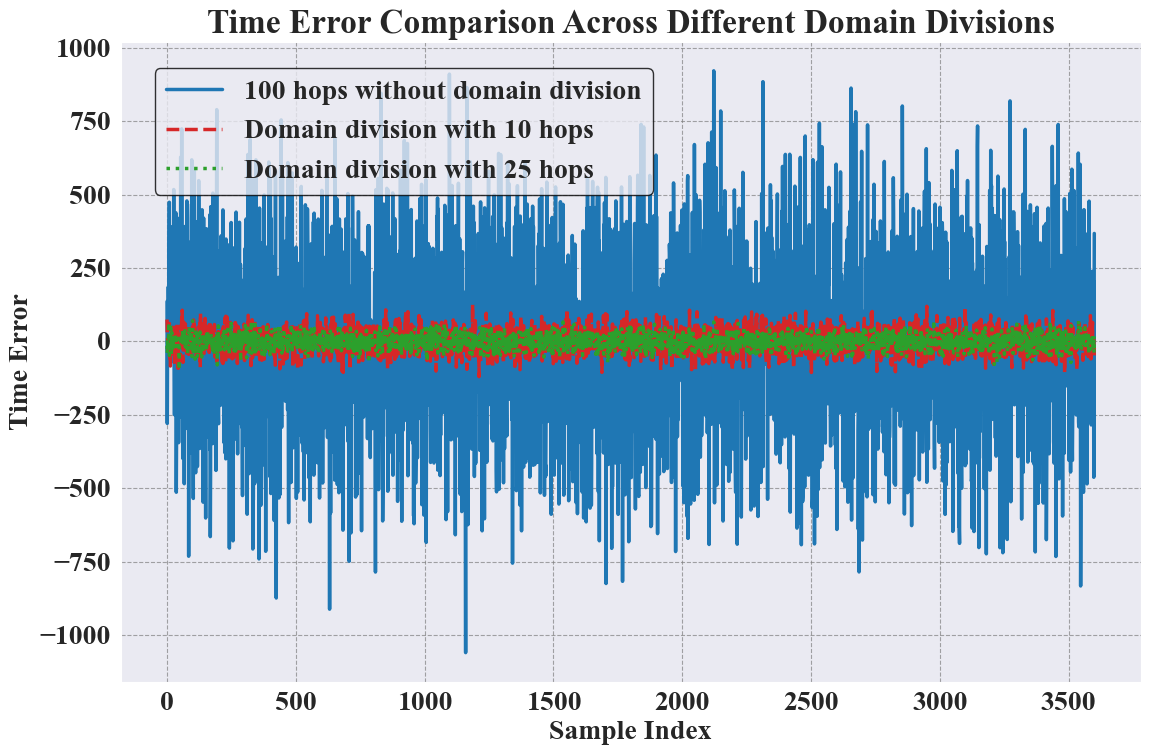

折线图已保存到: output_domains\time_error_comparison.png

所有处理完成！


In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 设置全局字体和字号
plt.rcParams.update({
    'font.size': 20,
    'font.family': 'serif',
    'font.serif': ['Times New Roman'],
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'mathtext.fontset': 'stix'
})

# 1. 定义文件路径
file1 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data\te_all_hops.csv"
file2 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data_domains\te_all_hops.csv"
file3 = r"D:\06_engineering\03_analysis\pj_gptp_simulation\version\20250429\output_data_25domains\te_all_hops.csv"

# 2. 创建输出目录
output_dir = "output_domains"
os.makedirs(output_dir, exist_ok=True)
print(f"数据将保存到: {output_dir}")

# 3. 数据预处理函数
def preprocess_data(data_col):
    """处理数据列，去除NaN值并转换为numpy数组"""
    data = data_col.values
    data = np.nan_to_num(data, nan=np.nanmean(data))
    return data

# 4. 读取并处理数据
try:
    # 读取第一组数据 (Hop_100)
    df1 = pd.read_csv(file1)
    print("\n文件1加载成功！前5行示例：")
    print(df1.head())
    
    data1 = preprocess_data(df1["Hop_100"])
    print(f"处理数据1: 有效数据点={len(data1)}")
    
    # 读取第二组数据 (Hop_11)
    df2 = pd.read_csv(file2)
    print("\n文件2加载成功！前5行示例：")
    print(df2.head())
    
    data2 = preprocess_data(df2["Hop_11"])
    print(f"处理数据2: 有效数据点={len(data2)}")
    
    # 读取第三组数据 (Hop_5)
    df3 = pd.read_csv(file3)
    print("\n文件3加载成功！前5行示例：")
    print(df3.head())
    
    data3 = preprocess_data(df3["Hop_5"])
    print(f"处理数据3: 有效数据点={len(data3)}")
    
except Exception as e:
    print(f"\n数据文件加载失败: {e}")
    raise

# 5. 创建结果DataFrame并保存
result_df = pd.DataFrame({
    "100 hops without domain division": data1,
    "Domain division with 10 hops": data2,
    "Domain division with 25 hops": data3
})

output_csv_path = os.path.join(output_dir, "data_domains.csv")
result_df.to_csv(output_csv_path, index=False)
print(f"\n所有数据已合并保存到: {output_csv_path}")

# 6. 绘制折线图
plt.figure(figsize=(12, 8))
ax = plt.gca()

# 定义线条样式
colors = ['#1f77b4', '#d62728', '#2ca02c']  # 蓝,红,绿
linestyles = ['-', '--', ':']
linewidths = [2.5, 2.5, 2.5]

# 绘制三组数据
x = np.arange(len(data1))  # 假设三组数据长度相同
ax.plot(x, data1, 
        color=colors[0], 
        linestyle=linestyles[0],
        linewidth=linewidths[0],
        label='100 hops without domain division')

ax.plot(x, data2, 
        color=colors[1], 
        linestyle=linestyles[1],
        linewidth=linewidths[1],
        label='Domain division with 10 hops')

ax.plot(x, data3, 
        color=colors[2], 
        linestyle=linestyles[2],
        linewidth=linewidths[2],
        label='Domain division with 25 hops')

# 设置图表属性
ax.set_xlabel('Sample Index', fontweight='bold')
ax.set_ylabel('Time Error', fontweight='bold')
ax.set_title('Time Error Comparison Across Different Domain Divisions', fontweight='bold')
ax.grid(True, which="both", linestyle='--', color='gray', alpha=0.7)

# 修改图例位置和样式 - 放在左上角内部
legend = ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98),
                  frameon=True, framealpha=0.8, edgecolor='black')

# 调整布局以留出足够空间
plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)

# 保存图表
output_plot_path = os.path.join(output_dir, "time_error_comparison.png")
plt.savefig(output_plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print(f"折线图已保存到: {output_plot_path}")

print("\n所有处理完成！")
